In [ ]:
# Install required dependencies for the trip planning system
# Core LangChain and LangGraph libraries for building AI agents and workflows
!pip install langchain langsmith langchain_community langchain_openai langgraph langchain_tavily langchain_unstructured ragatouille unstructured bs4 faiss-cpu rank_llm torch praw amadeus langchain-xai

#Importing libraries

In [ ]:
# Core environment and configuration
from google.colab import userdata  # For accessing stored API keys in Colab
import os  # Environment variable management
import asyncio  # Asynchronous programming support
import hashlib  # For generating document hashes
import uuid  # For generating unique identifiers
import json  # JSON data handling
import re  # Regular expressions for text processing
import httpx  # HTTP client for API requests
import requests  # HTTP requests library
from datetime import date, datetime  # Date and time handling
from enum import Enum  # Enumeration support
from functools import wraps  # Function decorators
from typing import List, Dict, Any, Optional, Annotated, Literal, Iterable, Union, Callable  # Type hints

# Pydantic for data validation and serialization
from pydantic import BaseModel, Field, BeforeValidator, model_validator, ConfigDict, computed_field, StringConstraints

# LangChain core components
from langchain import OpenAI
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.vectorstores import VectorStoreRetriever, VectorStore
from langchain_core.tools import tool, Tool
from langchain_core.messages import convert_to_messages, ToolMessage, HumanMessage, AIMessage, AnyMessage
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.prompts import PromptTemplate

# LangChain OpenAI integration
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# LangChain community components
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.document_compressors.rankllm_rerank import RankLLMRerank
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_community.tools.reddit_search.tool import RedditSearchRun, RedditSearchSchema
from langchain_community.utilities.reddit_search import RedditSearchAPIWrapper

# LangChain text processing
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_unstructured import UnstructuredLoader

# LangChain retrieval and compression
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain.tools.retriever import create_retriever_tool

# LangChain agents
from langchain.agents import AgentExecutor

# LangGraph for workflow orchestration
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.runtime import Runtime
from langgraph.types import interrupt, Command

# LangSmith for tracing and monitoring
import langsmith
from langsmith import traceable

# External search and content APIs
from langchain_tavily import TavilySearch, TavilyExtract

# Vector storage and similarity search
import faiss
import torch

# Web scraping and content processing
from bs4 import SoupStrainer

# External travel APIs
from amadeus import Client, ResponseError

# Alternative LLM provider
from langchain_xai import ChatXAI

# Display utilities
from IPython.display import Image, display

#Planning agent
This notebook is setting up a travel planning agent using LangGraph and various tools like Tavily Search, Reddit Search, and TripAdvisor API. It includes components for:

- Installing necessary libraries.
- Setting up API keys and environment variables.
- Configuring a language model (LLM).
- Building a RAG (Retrieval Augmented Generation) pipeline with document splitting, embedding, vector storage (FAISS), prefiltering, and reranking.
- Creating tools for searching the internet, Reddit, and TripAdvisor, as well as a tool for getting coordinates.
- Defining Pydantic models for various inputs, outputs, and the agent's state, including detailed schemas for budget estimation, research planning, candidate selection (lodging, activities, food, transport), recommendations, and the final trip plan.
- Implementing nodes for different stages of the planning process (budget estimation, research planning, research execution for various categories, and planning).
- Including a human-in-the-loop node for user selection of lodging and transport options.
- Constructing and compiling a LangGraph workflow to orchestrate these components.

In [ ]:
# API Key Configuration
# Retrieve API keys from Colab userdata for secure access
# These keys enable access to various external services used by the trip planning system

TAVILY_API_KEY = userdata.get('tavily')  # Tavily search API for internet search
OPEN_AI_KEY = userdata.get('chatgpt')    # OpenAI API for GPT models
LANGSMITH_API_KEY = userdata.get('langsmith')  # LangSmith for tracing and monitoring
TRIP_ADVISOR_API = userdata.get('tripadvisor')  # TripAdvisor Content API
RAPID_API = userdata.get('rapid_api')    # RapidAPI for additional services
AMADEUS_API = userdata.get('amedeus')    # Amadeus API for flight data
AMADEUS_SECRET = userdata.get('amadeus_secret')  # Amadeus API secret
XAI_API = userdata.get('xai')            # XAI API for alternative LLM provider

In [ ]:
# Environment Variable Setup
# Configure environment variables for LangChain tracing and API access
# This enables monitoring, debugging, and proper API authentication

os.environ["LANGCHAIN_TRACING_V2"] = "true"  # Enable LangSmith tracing
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"  # LangSmith endpoint
os.environ["LANGCHAIN_API_KEY"] = LANGSMITH_API_KEY  # LangSmith API key
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY  # Tavily search API key
os.environ["OPENAI_API_KEY"] = OPEN_AI_KEY  # OpenAI API key
os.environ["RAPID_API_KEY"] = RAPID_API  # RapidAPI key

In [ ]:
# Language Model Configuration
# Initialize the primary language model for the trip planning system
# Using XAI's Grok model for fast reasoning capabilities

# Note: The OpenAI model is commented out in favor of XAI's Grok model
# llm = ChatOpenAI(model="gpt-5-mini-2025-08-07", temperature=0, api_key=OPEN_AI_KEY)

# Primary LLM: XAI Grok model for fast reasoning
llm = ChatXAI(
    model="grok-4-fast-reasoning",  # Fast reasoning model for complex trip planning
    temperature=0,  # Low temperature for consistent, deterministic outputs
    api_key=XAI_API  # XAI API key for authentication
)

# Rag
Making our rag pipeline

This section sets up the Retrieval Augmented Generation (RAG) pipeline components:

- **Splitting Documents**: Uses `RecursiveCharacterTextSplitter` to break down large documents into smaller, manageable chunks for better processing.
- **Creating Vector Storage**: Initializes a FAISS vector store with OpenAI embeddings to efficiently store and search document chunks based on their semantic similarity.
- **Adding Unique Documents**: Implements a function to generate unique IDs for documents using hashing and adds only new, unique documents to the FAISS vector store.
- **Prefiltering**: Defines a function to perform a preliminary filtering of retrieved documents based on relevance scores before reranking.
- **Reranking**: Sets up a cross-encoder reranker model to reorder the prefiltered documents and select the most relevant ones based on their score.

In [ ]:
# Document Splitting Configuration
# Configure text splitter for optimal chunk processing
splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,  # Optimal chunk size for semantic processing
    chunk_overlap=100,  # Overlap to maintain context between chunks
    separators=[r"\n{2,}", r"\n#{1,6}\s", "\n\n", "\n", " ", "", "!", "?", ".", '\t']  # Hierarchical separators
)

async def split_docs(docs: List[Document]) -> List[Document]:
    """
    Split documents into smaller chunks for better processing.
    
    This function takes a list of documents and splits them into smaller,
    more manageable chunks using the configured text splitter. This is
    essential for the RAG pipeline as it allows for better semantic
    understanding and retrieval.
    
    Args:
        docs (List[Document]): List of documents to split
        
    Returns:
        List[Document]: List of split document chunks
        
    Example:
        >>> documents = [Document(page_content="Long text...")]
        >>> chunks = await split_docs(documents)
        >>> print(f"Split into {len(chunks)} chunks")
    """
    if not docs:
        return []

    # Use async transformation for better performance
    splitted_doc = await splitter.atransform_documents(docs)
    return splitted_doc


In [ ]:
# Vector Storage Configuration
# Initialize FAISS vector store with OpenAI embeddings for semantic search

# Configure OpenAI embeddings for high-dimensional semantic representation
embedding = OpenAIEmbeddings(
    api_key=OPEN_AI_KEY,  # OpenAI API key
    model="text-embedding-3-large",  # Latest embedding model with high accuracy
    dimensions=1024  # High-dimensional embeddings for better semantic understanding
)

# Initialize FAISS vector store with optimized configuration
vector_store = FAISS(
    index=faiss.IndexHNSWFlat(1024, 32, faiss.METRIC_INNER_PRODUCT),  # HNSW index for fast similarity search
    docstore=InMemoryDocstore(),  # In-memory document storage
    embedding_function=embedding,  # OpenAI embedding function
    index_to_docstore_id={},  # Mapping between index and document IDs
    normalize_L2=True,  # L2 normalization for consistent similarity scores
    relevance_score_fn=lambda d: float(1.0 / (1.0 + float(d)))  # Custom relevance scoring function
)

# Create retriever for document search
retriever = vector_store.as_retriever(search_kwargs={"k": 20})  # Retrieve top 20 most similar documents

In [ ]:
def generate_doc_id(doc: Document) -> str:
    """
    Generate a unique hash ID for a document based on its content.
    
    This function creates a SHA-256 hash of the document's page content
    to serve as a unique identifier. This ensures that identical documents
    are not stored multiple times in the vector database.
    
    Args:
        doc (Document): The document to generate an ID for
        
    Returns:
        str: A hexadecimal string representing the document's hash
        
    Example:
        >>> doc = Document(page_content="Sample text")
        >>> doc_id = generate_doc_id(doc)
        >>> print(f"Document ID: {doc_id}")
    """
    return hashlib.sha256(doc.page_content.encode("utf-8")).hexdigest()

async def add_unique_documents(vector_store: FAISS, docs: List[Document]) -> List[str]:
    """
    Add unique documents to the vector store, preventing duplicates.
    
    This function processes a list of documents and adds only those that
    don't already exist in the vector store. It uses content-based hashing
    to identify duplicates and maintains the integrity of the knowledge base.
    
    Args:
        vector_store (FAISS): The FAISS vector store to add documents to
        docs (List[Document]): List of documents to potentially add
        
    Returns:
        List[str]: List of document IDs that were successfully added
        
    Example:
        >>> documents = [Document(page_content="New content")]
        >>> added_ids = await add_unique_documents(vector_store, documents)
        >>> print(f"Added {len(added_ids)} new documents")
    """
    unique_docs = {}

    for doc in docs:
        curr_doc = doc.page_content
        doc_id = generate_doc_id(doc)

        # Check if the document ID already exists in the docstore
        if doc_id not in vector_store.index_to_docstore_id.values():
            unique_docs[curr_doc] = doc_id

    if unique_docs:
        return await vector_store.aadd_texts(list(unique_docs.keys()), ids=list(unique_docs.values()))

    return []

In [ ]:
async def prefilter(query: str, docs: List[Document], k: int = 10) -> List[Document]:
    """
    Filter documents based on their similarity to a query using FAISS.
    
    This function performs a preliminary filtering step in the RAG pipeline.
    It creates a temporary FAISS index from the input documents and performs
    similarity search to identify the most relevant documents before the
    more expensive reranking step.
    
    Args:
        query (str): The search query to filter documents by
        docs (List[Document]): List of documents to filter
        k (int, optional): Number of top documents to return. Defaults to 10.
        
    Returns:
        List[Document]: List of filtered documents sorted by relevance
        
    Example:
        >>> query = "best restaurants in Tokyo"
        >>> filtered = await prefilter(query, documents, k=5)
        >>> print(f"Found {len(filtered)} relevant documents")
    """
    if not docs:
        return []

    # Create temporary FAISS index for similarity search
    filtered_docs: VectorStore = await FAISS.afrom_documents(
        docs, 
        embedding, 
        normalize_L2=True, 
        relevance_score_fn=lambda d: float(1.0 / (1.0 + float(d)))
    )

    # Set similarity threshold for quality control
    score_threshold = {"score_threshold": 0.3}

    # Perform similarity search with relevance scores
    filtered_docs = await filtered_docs.asimilarity_search_with_relevance_scores(
        query, k=k, **score_threshold
    )

    # Extract documents from (document, score) tuples
    return [doc for doc, _ in filtered_docs]

In [ ]:
class DefaultInput(BaseModel):
    """
    Base input model for all search and retrieval operations.
    
    This class serves as the foundation for all input schemas in the system.
    It provides a common structure with a query field that can be extended
    by more specific input models for different types of searches.
    
    Attributes:
        query (str): The search query or question to process
        
    Example:
        >>> input_data = DefaultInput(query="best restaurants in Paris")
        >>> print(input_data.query)
    """
    query: str = Field(description="Questions")

    model_config = ConfigDict(arbitrary_types_allowed=True)

In [ ]:
# Document Reranking Configuration
# Set up cross-encoder model for precise document reranking

class RerankInput(DefaultInput):
    """
    Input model for document reranking operations.
    
    Extends the base DefaultInput to include document-specific parameters
    for the reranking process. This allows for fine-tuned control over
    the reranking behavior.
    
    Attributes:
        docs (List[Document]): List of documents to rerank
        top_n (Optional[int]): Number of top documents to return after reranking
    """
    docs: List[Document] = Field(description="List of documents you want to rerank")
    top_n: Optional[int] = Field(default=10, description="Number of documents to return after reranking")

# Initialize cross-encoder model for reranking
model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")

async def rerank(input: RerankInput) -> List[Document]:
    """
    Rerank documents using a cross-encoder model for improved relevance.
    
    This function performs the final reranking step in the RAG pipeline.
    It uses a cross-encoder model to compute precise relevance scores
    between the query and each document, providing better ranking than
    simple similarity search.
    
    Args:
        input (RerankInput): Input containing query, documents, and top_n parameter
        
    Returns:
        List[Document]: List of reranked documents sorted by relevance score
        
    Example:
        >>> rerank_input = RerankInput(
        ...     query="best restaurants in Tokyo",
        ...     docs=documents,
        ...     top_n=5
        ... )
        >>> reranked = await rerank(rerank_input)
        >>> print(f"Reranked {len(reranked)} documents")
    """
    if not input.docs:
        return []

    # Initialize reranker with cross-encoder model
    reranker = CrossEncoderReranker(model=model, top_n=input.top_n)

    # Perform reranking with query-document relevance scoring
    reranked_docs = await reranker.acompress_documents(input.docs, input.query)

    return reranked_docs

#Prefilter test

In [ ]:
# Sample documents for testing the RAG pipeline
# These documents represent different topics to test the filtering and reranking capabilities
sample_documents = [
    Document(page_content="This is about machine learning and AI", metadata={"source": "doc1"}),
    Document(page_content="Python programming tutorial for beginners", metadata={"source": "doc2"}),
    Document(page_content="Data science with pandas and numpy", metadata={"source": "doc3"}),
    Document(page_content="Web development using Flask and Django", metadata={"source": "doc4"}),
    Document(page_content="Deep learning neural networks", metadata={"source": "doc5"}),
]

In [ ]:
# Test the prefiltering functionality
# This demonstrates how the system filters documents based on query relevance
await prefilter("What is deep learning?", sample_documents)

[Document(id='1515f435-f92c-482c-b0f3-c83659045659', metadata={'source': 'doc5'}, page_content='Deep learning neural networks'),
 Document(id='8911286f-9ab8-4c5b-9725-18c27010f384', metadata={'source': 'doc1'}, page_content='This is about machine learning and AI'),
 Document(id='52657f73-b7f2-48c9-b4be-1db209a23761', metadata={'source': 'doc3'}, page_content='Data science with pandas and numpy'),
 Document(id='23d39ce8-a99a-4f47-8974-641b8344f287', metadata={'source': 'doc2'}, page_content='Python programming tutorial for beginners'),
 Document(id='d7c98780-f8ea-4e40-b661-4db0a88c0665', metadata={'source': 'doc4'}, page_content='Web development using Flask and Django')]

# Retrieve
Creating a tool that retrieves documents from the vector database

In [ ]:
# Document Retrieval Configuration
# Define input schema and retrieval tool for database searches

class RetrieverInput(DefaultInput):
    """
    Input model for database retrieval operations.
    
    Extends the base DefaultInput to include parameters for controlling
    the retrieval process, including prefiltering and reranking limits.
    
    Attributes:
        top_n (Optional[int]): Number of documents to return after reranking
        k (Optional[int]): Number of documents to return after prefiltering
    """
    top_n: Optional[int] = Field(default=10, description="Number of documents to retrieve after reranking")
    k: Optional[int] = Field(default=20, description="Number of documents to return after prefiltering")

@tool
async def search_db(input: RetrieverInput) -> List[Document]:
    """
    Search the vector database using the complete RAG pipeline.
    
    This tool implements the full document retrieval workflow:
    1. Initial vector search in the FAISS database
    2. Prefiltering based on similarity scores
    3. Reranking using cross-encoder models
    4. Return top-k most relevant documents
    
    Args:
        input (RetrieverInput): Input containing query and retrieval parameters
        
    Returns:
        List[Document]: List of relevant documents sorted by relevance
        
    Example:
        >>> search_input = RetrieverInput(
        ...     query="best restaurants in Paris",
        ...     top_n=5,
        ...     k=15
        ... )
        >>> results = await search_db.ainvoke({"input": search_input})
        >>> print(f"Found {len(results)} relevant documents")
    """
    # Step 1: Initial vector search in the database
    documents = await retriever.ainvoke(input.query)

    # Step 2: Prefilter documents based on similarity scores
    filtered_docs = await prefilter(query=input.query, docs=documents, k=input.k)

    # Step 3: Rerank documents using cross-encoder model
    reranked_docs = await rerank(RerankInput(query=input.query, docs=filtered_docs, top_n=input.top_n))
    
    return reranked_docs

# Reddit search

Creating a tool that searches reddit

This section defines the components for searching Reddit and processing the results:

- **Helper Function `to_doc`**: Converts dictionary-like items from Reddit search results into `Document` objects, standardizing the format for further processing.
- **Helper Function `parse_reddit_results`**: Parses the raw string output from the Reddit search API into a structured list of `Document` objects, extracting relevant information like title, text, URL, subreddit, author, and score.
- **Reddit Search Tool `search_reddit`**: Defines a tool that takes a query and other parameters (like time filter, sort, subreddit, and limit) to search Reddit. It then uses the helper functions to parse the results, splits the documents into chunks, prefilters them, saves unique documents to the vector store, and finally reranks the results to return the most relevant documents.

In [ ]:
# Reddit Data Processing Helper Functions
# Functions to convert Reddit post data into standardized Document objects

def to_doc(item, *, source: str) -> Document:
    """
    Convert Reddit post data into a standardized Document object.
    
    This helper function normalizes Reddit post data (from various formats)
    into a consistent Document structure that can be processed by the RAG pipeline.
    It extracts title, text content, and URL information while preserving
    all original metadata.
    
    Args:
        item: Reddit post data (dict or other format)
        source (str): Source identifier for the document
        
    Returns:
        Document: Standardized document object with page content and metadata
        
    Example:
        >>> reddit_post = {"title": "Best restaurants", "text": "Great food here"}
        >>> doc = to_doc(reddit_post, source="reddit")
        >>> print(doc.page_content)
    """
    # Extract title from various possible fields
    title = item.get("title", "") if isinstance(item, dict) else ""
    
    # Extract text content from various possible fields
    text = item.get("text") or item.get("selftext") or item.get("body") or ""
    
    # Extract URL from various possible fields
    url = item.get("url") or item.get("permalink") or ""
    
    # Combine title and text for page content
    page_content = f"{title}\n\n{text}".strip() or title or url
    
    # Create document with content and metadata
    return Document(
        page_content=page_content, 
        metadata={"source": source, **(item if isinstance(item, dict) else {})}
    )

In [ ]:
def parse_reddit_results(payload: Any) -> List[Document]:
    """
    Parse raw Reddit search results into structured Document objects.
    
    This function processes the raw string output from the Reddit search API
    and extracts structured information about each post, including title,
    author, subreddit, content, URL, category, and score.
    
    Args:
        payload: Raw Reddit API response (string or dict with "result" key)
        
    Returns:
        List[Document]: List of parsed Reddit posts as Document objects
        
    Example:
        >>> raw_response = "Post Title: Best restaurants in Tokyo\\nUser: traveler123..."
        >>> docs = parse_reddit_results(raw_response)
        >>> print(f"Parsed {len(docs)} Reddit posts")
    """
    # Regular expression pattern to extract Reddit post information
    POST_PATTERN = re.compile(
        r"""
        Post\ Title:\s*(?P<title>.*?)\n
        \s*User:\s*(?P<user>.*?)\n
        \s*Subreddit:\s*(?P<subreddit>.*?)\s*:?\s*\n
        \s*Text\ body:\s*(?P<body>.*?)
        \s*Post\ URL:\s*(?P<url>\S+)\n
        \s*Post\ Category:\s*(?P<category>.*?)\.\s*\n
        \s*Score:\s*(?P<score>\d+)
        """,
        re.DOTALL | re.VERBOSE,
    )

    # Extract text from payload (handle both string and dict formats)
    text = payload.get("result") if isinstance(payload, dict) and "result" in payload else payload
    if not isinstance(text, str):
        return []

    docs: List[Document] = []

    # Parse each Reddit post using the regex pattern
    for m in POST_PATTERN.finditer(text):
        # Extract and clean post information
        title = m.group("title").strip().strip("'\"")
        user = m.group("user").strip()
        subreddit = m.group("subreddit").strip()
        body = m.group("body").strip()
        url = m.group("url").strip()
        category = m.group("category").strip()
        score_str = m.group("score").strip()
        
        # Convert score to integer, handle errors gracefully
        try:
            score = int(score_str)
        except ValueError:
            score = None

        # Normalize subreddit (remove trailing colon if present)
        if subreddit.endswith(":"):
            subreddit = subreddit[:-1].strip()

        # Compose page content for the document
        page_content = f"{title}\n\n{body}".strip() if (title or body) else url

        # Remove URLs from content to avoid noise in embeddings
        page_content = re.sub(r"https?://\S+", "", page_content)
        
        # Create document with structured metadata
        docs.append(
            Document(
                page_content=page_content,
                metadata={
                    "source": "reddit",
                    "title": title,
                    "url": url,
                    "subreddit": subreddit,
                    "author": user,
                    "category": category,
                    "score": score,
                },
            )
        )
    return docs

In [ ]:
# Reddit Search Tool Configuration
# Set up Reddit API client and search tool with comprehensive parameters

class RedditSearchInput(DefaultInput):
    """
    Input model for Reddit search operations.
    
    Extends the base DefaultInput to include Reddit-specific search parameters
    for controlling the search behavior, including time filters, sorting,
    subreddit targeting, and result limits.
    
    Attributes:
        time_filter: Time range for search results
        sort: Sorting method for results
        subreddit: Target subreddit (default: "all")
        limit: Number of Reddit posts to retrieve
        top_n: Number of documents to return after reranking
        k: Number of documents to return after prefiltering
    """
    time_filter: Literal["year", "week", "month", "all", "day", "hour"] = Field(description="Time filter for search")
    sort: Literal["relevance", "hot", "top", "new", "comments"] = Field(description="Sort results by")
    subreddit: Optional[str] = Field(default="all", description="Subreddit to search in")
    limit: Optional[int] = Field(default=20, description="Number of reddit posts to return")
    top_n: Optional[int] = Field(default=10, description="Number of documents to return after reranking")
    k: Optional[int] = Field(default=20, description="Number of documents to return after prefiltering")

# Reddit API configuration
user_agent = "langchain_reddit_bot/0.1 by u/CorgiZealousideal407"
client_id = userdata.get('reddit_client_id')
REDDIT_KEY = userdata.get('reddit')

# Initialize Reddit search wrapper
reddit_search = RedditSearchRun(
    api_wrapper=RedditSearchAPIWrapper(
        reddit_client_id=client_id,
        reddit_client_secret=REDDIT_KEY,
        reddit_user_agent=user_agent,
    ),
    description="A tool that searches reddit posts"
)

@tool
async def search_reddit(input: RedditSearchInput) -> List[Document]:
    """
    Search Reddit for travel-related information and process results through RAG pipeline.
    
    This tool performs a comprehensive Reddit search workflow:
    1. Search Reddit posts based on query and filters
    2. Parse raw results into structured documents
    3. Split documents into chunks for better processing
    4. Prefilter results based on relevance scores
    5. Save unique documents to the vector store
    6. Rerank results using cross-encoder models
    
    Args:
        input (RedditSearchInput): Search parameters including query, filters, and limits
        
    Returns:
        List[Document]: List of relevant Reddit posts as Document objects
        
    Example:
        >>> search_input = RedditSearchInput(
        ...     query="best restaurants in Tokyo",
        ...     subreddit="travel",
        ...     limit=10,
        ...     top_n=5
        ... )
        >>> results = await search_reddit.ainvoke({"input": search_input})
        >>> print(f"Found {len(results)} relevant Reddit posts")
    """
    # Step 1: Search Reddit using the API wrapper
    search_params = RedditSearchSchema(
        query=input.query,
        sort=input.sort,
        time_filter=input.time_filter,
        subreddit=input.subreddit,
        limit=str(input.limit)
    )

    search_res: str = await reddit_search.arun(search_params.model_dump())

    # Step 2: Parse raw Reddit results into structured documents
    res_doc = parse_reddit_results(search_res)

    # Step 3: Split documents into chunks for better processing
    splitted_docs = await split_docs(res_doc)

    # Step 4: Prefilter documents based on relevance scores
    filtered_docs = await prefilter(query=input.query, docs=splitted_docs, k=input.k)

    # Step 5: Create concurrent tasks for saving and reranking
    save_task = add_unique_documents(vector_store=vector_store, docs=filtered_docs)
    rerank_input = RerankInput(query=input.query, docs=filtered_docs, top_n=input.top_n)
    reranked_output_task = rerank(rerank_input)

    # Step 6: Execute tasks concurrently for better performance
    res = await asyncio.gather(save_task, reranked_output_task)

    return res[1]  # Return reranked results

#Reddit search test

In [ ]:
# Test Reddit search with a travel-related query
# This demonstrates the complete Reddit search workflow
results = await search_reddit.ainvoke({
    "input": {
        "query": "restaurants for couples in korea",
        "time_filter": "week",
        "sort": "relevance",
        "limit": 50,
        "top_n": 5,
        "k": 10
    }
})

In [ ]:
# Display the search results
# These are the processed Reddit posts relevant to the query
results

[Document(id='8f3ff770-af19-4283-978b-4ecad34c3753', metadata={'source': 'reddit', 'title': 'Korean Restaurants for Solo Diners near Hongdae (Where Locals Actually Go)', 'url': 'https://www.reddit.com/r/KoreaExperience/comments/1nllawv/korean_restaurants_for_solo_diners_near_hongdae/', 'subreddit': 'r/KoreaExperience', 'author': 'Lopsided_Papaya2485', 'category': 'N/A', 'score': 20}, page_content='---\n\n**[Geunyeoui Bapsang (그녀의밥상)](\n\nIt is a homestyle Korean restaurant in Hongdae specializing in hearty set meals (bapsang). It offers a variety of affordable and satisfying dishes such as stir-fried pork, grilled mackerel, and soybean paste stews, all served with unlimited rice and side dishes. With its casual and welcoming atmosphere, it’s a popular spot for both solo diners and small groups looking for a simple, filling Korean meal.\n\n**Atmosphere**  \n\\#HomestyleKorean, #Affordable, #UnlimitedRefills, #SoloFriendly, #ModerateForeignVisitors'),
 Document(id='404f8a59-b566-4c38-87c

# Search the Internet

This section defines the components for searching the internet using Tavily and processing the results:

- **Helper Function `process_pages`**: Cleans and filters the raw content retrieved from web pages, removing URLs, extra whitespace, and short or empty content.
- **Internet Search Tool `search_internet`**: Defines a tool that uses Tavily Search and Tavily Extract to search the web for information based on a query and specified parameters (country, search depth, max results). It retrieves content from the resulting URLs, processes the pages using the helper function, splits the cleaned documents into chunks, prefilters them based on relevance, saves unique documents to the vector store, and finally reranks the results to return the most relevant documents.

In [ ]:
# Web Content Processing
# Function to clean and filter web page content for better processing

def process_pages(docs: List[Document]) -> List[Document]:
    """
    Clean and filter web page content for better processing.
    
    This function processes raw web page content by removing noise,
    normalizing formatting, and filtering out low-quality content.
    It ensures that only meaningful, clean content is passed to
    the embedding and retrieval systems.
    
    Args:
        docs (List[Document]): List of documents with raw web content
        
    Returns:
        List[Document]: List of cleaned documents with meaningful content
        
    Example:
        >>> raw_docs = [Document(page_content="Raw web content with URLs...")]
        >>> cleaned = process_pages(raw_docs)
        >>> print(f"Cleaned {len(cleaned)} documents")
    """
    if not docs:
        return []

    cleaned_docs = []
    for doc in docs:
        if doc.page_content and doc.page_content.strip():
            t = doc.page_content

            # Remove URLs and links to reduce noise in embeddings
            t = re.sub(r'https?://\S+', '', t)  # Remove http/https URLs
            t = re.sub(r'www\.\S+', '', t)     # Remove www. URLs

            # Normalize whitespace and formatting
            t = re.sub(r'\n{2,}', '\n\n', t)   # Multiple newlines to double
            t = re.sub(r"[ \t\u00a0]{2,}", " ", t)  # Multiple spaces to single
            t = re.sub(r"\r", "", t)           # Remove carriage returns

            # Update document content with cleaned text
            doc.page_content = t.strip()

            # Only keep documents with meaningful content after cleaning
            if len(doc.page_content) > 50:
                cleaned_docs.append(doc)

    return cleaned_docs

In [ ]:
# Internet Search Tool Configuration
# Set up Tavily search and extraction for comprehensive web search

class InternetSearchInput(DefaultInput):
    """
    Input model for internet search operations.
    
    Extends the base DefaultInput to include web search-specific parameters
    for controlling the search behavior, including country targeting,
    search depth, and result limits.
    
    Attributes:
        country: Target country for search results
        search_depth: Search depth level (basic/advanced)
        max_results: Maximum number of URLs to search
        top_n: Number of documents to return after reranking
        k: Number of documents to return after prefiltering
    """
    country: str = Field(description="Country to search in")
    search_depth: Literal["basic", "advanced"] = Field(default="basic", description="Depth of search")
    max_results: Optional[int] = Field(default=5, description="Number of urls to return from the internet search")
    top_n: Optional[int] = Field(default=10, description="Number of documents to return after reranking")
    k: Optional[int] = Field(default=20, description="Number of documents to return after prefiltering")

@tool
async def search_internet(input: InternetSearchInput) -> List[Document]:
    """
    Search the internet for travel information and process results through RAG pipeline.
    
    This tool performs a comprehensive web search workflow:
    1. Search the web using Tavily for relevant URLs
    2. Extract content from discovered web pages
    3. Process and clean the extracted content
    4. Split documents into chunks for better processing
    5. Prefilter results based on relevance scores
    6. Save unique documents to the vector store
    7. Rerank results using cross-encoder models
    
    Args:
        input (InternetSearchInput): Search parameters including query, country, and limits
        
    Returns:
        List[Document]: List of relevant web content as Document objects
        
    Example:
        >>> search_input = InternetSearchInput(
        ...     query="Best places for couples to visit in Japan in 2025 September",
        ...     country="japan",
        ...     search_depth="basic",
        ...     max_results=5,
        ...     top_n=10
        ... )
        >>> results = await search_internet.ainvoke({"input": search_input})
        >>> print(f"Found {len(results)} relevant web documents")
    """
    # Step 1: Initialize Tavily search with configured parameters
    tavily_search = TavilySearch(
        max_results=input.max_results,
        tavily_api_key=TAVILY_API_KEY,
        search_depth=input.search_depth,
        country=input.country
    )

    # Initialize Tavily extractor for content extraction
    tavily_extract = TavilyExtract()

    # Step 2: Search the web for relevant URLs
    tavily_results = await tavily_search.ainvoke(input.query)
    urls = [result.get('url') for result in tavily_results.get('results') if result.get('url')]

    if not urls:
        return []

    # Step 3: Extract content from discovered URLs
    extr_res = await tavily_extract.ainvoke({"urls": urls})

    # Step 4: Convert extracted content to Document objects
    loaded_docs = []
    for res in extr_res['results']:
        loaded_docs.append(Document(
            page_content=res.get('raw_content'), 
            metadata={"source": "tavily", "url": res.get('url')}
        ))

    # Step 5: Process and clean the web content
    loaded_docs = process_pages(loaded_docs)

    # Step 6: Split documents into chunks for better processing
    splitted_docs = await split_docs(loaded_docs)
    
    # Step 7: Prefilter documents based on relevance scores
    filtered_docs = await prefilter(query=input.query, docs=splitted_docs, k=input.k)

    if not filtered_docs:
        return []

    # Step 8: Create concurrent tasks for saving and reranking
    docs_to_db = add_unique_documents(vector_store=vector_store, docs=filtered_docs)
    rerank_input = RerankInput(query=input.query, docs=filtered_docs, top_n=input.top_n)
    rerank_output = rerank(rerank_input)

    # Step 9: Execute tasks concurrently for better performance
    res = await asyncio.gather(docs_to_db, rerank_output, return_exceptions=True)
    if res[1]:
        return res[1]

    return []

#Internet search test

In [ ]:
# Test internet search with a travel-related query
# This demonstrates the complete web search workflow
internet_search = await search_internet.ainvoke({
    "input": {
        "query": "Best restaurants for couple to visit in Tokyo in 2025 september",
        "country": "japan",
        "search_depth": "basic",
        "max_results": 3,
        "top_n": 10,
        "k": 20
    }
})

In [ ]:
# Display the internet search results
# These are the processed web documents relevant to the query
internet_search

[Document(id='611a6199-5f8c-4c53-bd74-921a9802e68d', metadata={'source': 'tavily', 'url': 'https://www.opentable.com/metro/tokyo-restaurants'}, page_content='More info\n\n [Tsuki\n\n ¥¥¥¥\n Price: Very Expensive\n • Japanese\n • Roppongi\n\n •4.5](\n\n### Frequently asked questions\n\nHealthy restaurants located in Tokyo include [神戸牛511]( [Essence]( and [Jinroku in TOKYO](\n\nBottomless brunch in Tokyo is available at [神戸牛511]( [TOSA DINING OKYAKU]( and [銀座焼肉Coco Nemaru Ginza （ここねまるぎんざ）](\n\nThe most romantic restaurant in Tokyo is [FUKUZUSHI -Important! The Menu order is mandatory](\n\n## Explore OpenTable'),
 Document(id='50b653f1-2a54-4946-9bd3-2baa7409a082', metadata={'source': 'tavily', 'url': 'https://www.tripadvisor.com/Restaurants-g298184-zfp3-Tokyo_Tokyo_Prefecture_Kanto.html'}, page_content='[* ![Image 94]( * ![Image 95](blob: * ![Image 96](blob:\n\n[29. Ikuta](\n\n4.7\n\n[(173 reviews)](\n\n3.2 mi\n\nYoyogi\n\nJapanese, Steakhouse$$ - $$$\n\nClosed now\n\n[Menu](\n\n[Get you

#Trip advisor tools
This section defines the components for interacting with the TripAdvisor Content API:

**Pydantic Models**: Defines various Pydantic models for structuring the input and output data for the TripAdvisor API calls. These include models for addresses, search queries, location details, photos, reviews, and a comprehensive location search result.

**TripAdvisor Class**: Implements an asynchronous client for the TripAdvisor Content API. This class handles the API key management, making GET requests to the specified endpoints (search, details, photos, reviews, nearby search, and comprehensive search), and processing the JSON responses into the defined Pydantic models.

**TripAdvisor Tools**: Creates several tools using the @tool decorator that wrap the methods of the TripAdvisor class. These tools provide a simplified interface for performing specific actions like searching for locations, getting location details, fetching photos, retrieving reviews, performing nearby searches, and executing a comprehensive search that combines multiple API calls for a single location.

In [ ]:
# TripAdvisor Data Models and Type Definitions
# Common constrained types for data validation and consistency

# Financial and geographic constraints
NonNegMoney = Annotated[float, Field(ge=0)]  # Non-negative monetary values
Lat = Annotated[float, Field(ge=-90, le=90)]  # Latitude bounds (-90 to 90)
Lon = Annotated[float, Field(ge=-180, le=180)]  # Longitude bounds (-180 to 180)
Rating = Annotated[float, Field(ge=0, le=5)]  # Rating scale (0 to 5)

# String format constraints
ISO4217 = Annotated[str, Field(pattern=r"^[A-Z]{3}$")]  # 3-letter currency codes
HttpURLStr = Annotated[str, StringConstraints(
    pattern=r"^https?://[^\s]+$", strip_whitespace=True, min_length=8, max_length=2048
)]  # Valid HTTP/HTTPS URLs
TimeHHMM = Annotated[str, StringConstraints(
    pattern=r"^([01]\d|2[0-3]):[0-5]\d$"
)]  # 24-hour time format (HH:MM)

# Supported language codes for TripAdvisor API
LanguageCode = Literal[
    "ar",      # Arabic
    "zh",      # Chinese (Simplified)
    "zh_TW",   # Chinese (Traditional)
    "da",      # Danish
    "nl",      # Dutch
    "en_AU",   # English (Australia)
    "en_CA",   # English (Canada)
    "en_HK",   # English (Hong Kong)
    "en_IN",   # English (India)
    "en_IE",   # English (Ireland)
    "en_MY",   # English (Malaysia)
    "en_NZ",   # English (New Zealand)
    "en_PH",   # English (Philippines)
    "en_SG",   # English (Singapore)
    "en_ZA",   # English (South Africa)
    "en_UK",   # English (United Kingdom)
    "en",      # English (United States)
    "fr",      # French
    "fr_BE",
    "fr_CA",
    "fr_CH",
    "de_AT",
    "de",
    "el",
    "iw",
    "in",
    "it",
    "it_CH",
    "ja",
    "ko",
    "no",
    "pt_PT",
    "pt",
    "ru",
    "es_AR",
    "es_CO",
    "es_MX",
    "es_PE",
    "es",
    "es_VE",
    "es_CL",
    "sv",
    "th",
    "tr",
    "vi"
]

In [ ]:
# TripAdvisor Core Data Models
# Base models for location and address information

class Address(BaseModel):
    """
    Address model for location information.
    
    Represents a complete address with all possible components
    for precise location identification and display.
    
    Attributes:
        street1: Primary street address
        street2: Secondary street address (apartment, suite, etc.)
        city: City name
        state: State or province
        country: Country name
        postalcode: Postal or ZIP code
        address_string: Complete formatted address string
    """
    street1: Optional[str] = Field(default=None, description="Street address")
    street2: Optional[str] = Field(default=None, description="Street address")
    city: Optional[str] = Field(default=None, description="City")
    state: Optional[str] = Field(default=None, description="State")
    country: Optional[str] = Field(default=None, description="Country")
    postalcode: Optional[str] = Field(default=None, description="Postal code")
    address_string: Optional[str] = Field(default=None, description="Full address")

    model_config = ConfigDict(extra="forbid")

#Nearby search
class NearbySearch(BaseModel):
  latLong: str=Field(description="Latitude/Longitude pair to scope down the search around a specifc point - eg. '42.3455,-71.10767'")
  category: Optional[Literal["attractions", "restaurants", "geos", "hotels"]]=Field(default=None, description="Filters result set based on property type. ")
  phone: Optional[str]=Field(default=None, description="Phone number to filter the search results by (this can be in any format with spaces and dashes but without the '+' sign at the beginning)")
  address: Optional[str]=Field(default=None, description="Address to filter the search results by")
  radius: Optional[int]=Field(default=None, ge=0, description="Length of the radius from the provided latitude/longitude pair to filter results.")
  radiusUnit: Optional[Literal["km", "mi", "m"]]=Field(default=None, description="Unit for length of the radius. Valid options are 'km', 'mi', 'm' (km=kilometers, mi=miles, m=meters)")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")

  model_config = ConfigDict(extra="forbid")

class NearbySearchData(BaseModel):
  location_id: str=Field(description="A unique identifier for a location on Tripadvisor. The location ID can be obtained using the Location Search.")
  name: str
  distance: str
  bearing: str
  address_obj: Address

  model_config = ConfigDict(extra="forbid")

class NearbySearchOutput(BaseModel):
  data: List[NearbySearchData]

#Location search
class SearchLocation(BaseModel):
  searchQuery: str=Field(description="Text to use for searching based on the name of the location")
  latLong: Optional[str]=Field(default=None, description="Latitude/Longitude pair to scope down the search around a specifc point - eg. '42.3455,-71.10767'")
  category: Optional[Literal["attractions", "restaurants", "geos", "hotels"]]=Field(default=None, description="Filters result set based on property type. ")
  phone: Optional[str]=Field(default=None, description="Phone number to filter the search results by (this can be in any format with spaces and dashes but without the '+' sign at the beginning)")
  address: Optional[str]=Field(default=None, description="Address to filter the search results by")
  radius: Optional[int]=Field(default=None, ge=0, description="Length of the radius from the provided latitude/longitude pair to filter results.")
  radiusUnit: Optional[Literal["km", "mi", "m"]]=Field(default=None, description="Unit for length of the radius. Valid options are 'km', 'mi', 'm' (km=kilometers, mi=miles, m=meters)")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")

class LocationData(BaseModel):
  location_id: str=Field(description="A unique identifier for a location on Tripadvisor. The location ID can be obtained using the Location Search.")
  name: str
  address_obj: Address

class LocationOutput(BaseModel):
  data: List[LocationData]

  model_config = ConfigDict(extra="forbid")

#Location details
class LocationDetails(BaseModel):
  locationId: str=Field(description="A unique identifier for a location on Tripadvisor. The location ID can be obtained using the Location Search.")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")
  currency: Optional[ISO4217]=Field(default="USD", description="The currency code to use for request and response (should follow ISO 4217).")

  model_config = ConfigDict(extra="forbid")

class DetailsOutput(BaseModel):
  location_id: str
  name: str
  description: Optional[str] = None
  web_url: Optional[HttpURLStr] = None
  address_obj: Optional[Address] = None
  latitude: Optional[Lat] = None
  longitude: Optional[Lon] = None
  website: Optional[HttpURLStr] = None
  rating: Optional[Rating] = None
  price_level: Optional[str] = None

  model_config = ConfigDict(extra="forbid")

#Location photos
class LocationPhotos(BaseModel):
  locationId: str=Field(description="A unique identifier for a location on Tripadvisor. The location ID can be obtained using the Location Search.")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")
  limit: Optional[int] = Field(default=None, description="The number of results to return")
  offset: Optional[int] = Field(default=None, description="The index of the first result")
  source: Optional[str] = Field(default=None,
                                description="""A comma-separated list of allowed photo sources.
                                Allowed values are 'Expert', 'Management',
                                'Traveler'.If not specified, allow photos from all sources."""
                                )

  model_config = ConfigDict(extra="forbid")


class Image(BaseModel):
  height: Optional[int] = None
  width: Optional[int] = None
  url: Optional[HttpURLStr] = None

class PhotosData(BaseModel):
  id: str
  caption: Optional[str] = Field(default=None, description="The caption of the photo.")
  published_date: Optional[str] = Field(default=None, description="The date when the photo was published.")
  image: Optional[Image] = Field(default=None, description="The URL of the photo.")

  model_config = ConfigDict(extra="forbid")

class PhotosOutput(BaseModel):
  data: List[PhotosData]

  model_config = ConfigDict(extra="forbid")

#Location reviews
class LocationReviews(BaseModel):
  locationId: str=Field(description="A unique identifier for a location on Tripadvisor. The location ID can be obtained using the Location Search.")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")
  limit: Optional[int] = Field(default=None, description="The number of results to return")
  offset: Optional[int] = Field(default=None, description="The index of the first result")

  model_config = ConfigDict(extra="forbid")

class ReviewData(BaseModel):
  id: str
  lang: LanguageCode
  location_id: str
  published_date: str
  rating: Optional[Rating]
  url: Optional[HttpURLStr]
  text: Optional[str]
  title: Optional[str] = None
  trip_type: Optional[str] = None
  travel_date: Optional[str] = None

class ReviewOutput(BaseModel):
  data: List[ReviewData]

  model_config = ConfigDict(extra="forbid")


class ComprehensiveLocationInput(BaseModel):
  searchQuery: str=Field(description="Text to use for searching based on the name of the location")
  latLong: Optional[str]=Field(default=None, description="Latitude/Longitude pair to scope down the search around a specifc point - eg. '42.3455,-71.10767'")
  category: Optional[Literal["attractions", "restaurants", "geos", "hotels"]]=Field(default=None, description="Filters result set based on property type. ")
  phone: Optional[str]=Field(default=None, description="Phone number to filter the search results by (this can be in any format with spaces and dashes but without the '+' sign at the beginning)")
  address: Optional[str]=Field(default=None, description="Address to filter the search results by")
  radius: Optional[int]=Field(default=None, ge=0, description="Length of the radius from the provided latitude/longitude pair to filter results.")
  radiusUnit: Optional[Literal["km", "mi", "m"]]=Field(default=None, description="Unit for length of the radius. Valid options are 'km', 'mi', 'm' (km=kilometers, mi=miles, m=meters)")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")

  limit_locations: Optional[int] = Field(default=None, description="The number of locations to return")
  photos_limit: Optional[int] = Field(default=None, description="The number of photos to return")
  reviews_limit: Optional[int] = Field(default=None, description="The number of reviews to return")

  currency: Optional[ISO4217] = Field(default="USD", description="The currency code to use for request and response (should follow ISO 4217).")
  offset_photos: Optional[int] = Field(default=None, description="The index of the first photo result")
  offset_reviews: Optional[int] = Field(default=None, description="The index of the first review result")

class ComprehensiveLocationResult(BaseModel):
  """Container for all location data"""
  location_id: str
  name: str
  address: Optional[Address] = None
  details: Optional[DetailsOutput] = None
  photos: Optional[PhotosOutput] = None
  reviews: Optional[ReviewOutput] = None
  error: Optional[str] = None


class TripAdvisor:
  """
  Async client for TripAdvisor Content API v1 (Location endpoints).

  Base URL default: "https://api.content.tripadvisor.com/api/v1"
  All requests add the `key=<API_KEY>` query parameter automatically.

  Parameters
  ----------
  api_key : Optional[str]
      API key for the TripAdvisor Content API. If not provided,
      the client will read the environment variable `TRIP_ADVISOR_API`.
  base_url : Optional[str]
      API base (default "https://api.content.tripadvisor.com/api/v1").
      Should NOT end with a trailing slash.
  """

  def __init__(self, api_key: Optional[str]=None, base_url: Optional[str] = "https://api.content.tripadvisor.com/api/v1"):
    self.api_key = api_key or os.getenv("TRIP_ADVISOR_API")
    if not self.api_key:
      raise RuntimeError("TRIP_ADVISOR_API environment variable not set")

    self._client = httpx.AsyncClient(
            base_url=base_url.rstrip("/"),
            headers={"accept": "application/json"},
            timeout=httpx.Timeout(15.0, connect=10.0),
        )
    self.api_url = base_url + "/location"


  async def aclose(self):
    await self._client.aclose()

  async def __aenter__(self):
      return self

  async def __aexit__(self, exc_type, exc, tb):
      await self._client.aclose()

  async def _aget(self, path: str, params: Dict[str, Any]) -> Dict[str, Any]:
    resp = await self._client.get(path, params=params)
    resp.raise_for_status()
    return resp.json()

  async def search_location(self, input: SearchLocation) -> LocationOutput:
    """
    The Location Search request returns up to 10 locations found by the given search query. Returns up to 10 locations found near the given latitude/longtitude.
    Args:
      input: SearchLocation
    Returns:
      dict
    Output example:
    {
    "data": [
      {
        "location_id": "24035984",
        "name": "Tokyo Restaurant",
        "address_obj": {
          "street1": "13 El Thawra St",
          "street2": "Korba",
          "city": "Cairo",
          "state": "Cairo Governorate",
          "country": "Egypt",
          "postalcode": "4460242",
          "address_string": "13 El Thawra St Korba, Cairo 4460242 Egypt"
        }
      }, ...
    }
    """
    params = {"key": self.api_key, **input.model_dump(exclude_none=True)}

    url = self.api_url + "/search"
    data = await self._aget(url, params)
    data_list = []

    for d in data['data']:
      data_list.append(
          LocationData(
              location_id=d['location_id'],
              name=d['name'],
              address_obj=Address(**d['address_obj']))
      )

    result = LocationOutput(data=data_list)
    return result

  async def location_details(self, input: LocationDetails)->DetailsOutput:
    """
    Returns dictionary of location details.
    Args:
      input: LocationDetails
    Returns:
      dict
    Output example:
    {
    "data": [
      {
        "id": 1006278594,
        "lang": "en",
        "location_id": 3307880,
        "published_date": "2025-05-07T09:58:08Z",
        "rating": 1,
        "helpful_votes": 1,
        "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s1.0-66827-5.svg",
        "url": "https://www.tripadvisor.com/ShowUserReviews-g14134337-d3307880-r1006278594-Reviews-Sky_Restaurant_634_Musashi-Oshiage_Sumida_Tokyo_Tokyo_Prefecture_Kanto.html?m=66827#review1006278594",
        "text": "I had high hopes for Musashi Sky Restaurant in Tokyo, especially given the 10,000 yen deposit, required formal dress code, and menu prices ranging from €135 to €185 per person (with many main courses incurring additional charges). I was expecting a premium fine dining experience comparable to Jules Verne in Paris or Atmosphere in Dubai. Sadly, what I got was one of the most disappointing dining experiences I’ve had at this price point.\n\nFrom the moment we walked in, the ambiance felt cold, minimalist, and uninviting—not at all the elegant or atmospheric setting you’d dress up for. But the real issues started with the food and service.\n\nI had requested a fish main course in advance, as I don’t eat meat. What I was served was a fried, low-grade fish in a basic tomato sauce, with bones still in it. It was not a proper fish dish by any fine dining standard—more like a cafeteria meal than something you’d expect from a high-end restaurant. I couldn’t eat it, and when I politely explained why, the only response was a brief “sorry.” No replacement, no alternative, no effort made.\n\nThe disappointment continued with the non-alcoholic wine pairing. Of the three wines, two were decent, but the third was completely undrinkable. I asked if I could simply switch it for one of the previous wines I had already tasted and liked, but was told that would come at an additional charge. Again, at this level, you expect flexibility and genuine hospitality—not rigid policies and upselling.\n\nIn short, the food was underwhelming, the service was inflexible and dismissive, and the atmosphere was forgettable. Musashi Sky may have a great view, but that’s where the positives end. If you’re looking for a true fine dining experience in Tokyo, I recommend you look elsewhere. This was a costly mistake I won’t repeat—and hope others can avoid.",
        "title": "Hugely Overpriced and Deeply Disappointing",
        "trip_type": "Solo travel",
        "travel_date": "2025-05-31",
        "user": {
          "username": "LiaMoon",
          "user_location": {
            "id": "null"
          },
          "avatar": {
            "thumbnail": "https://media-cdn.tripadvisor.com/media/photo-t/27/b3/8e/c5/caption.jpg",
            "small": "https://media-cdn.tripadvisor.com/media/photo-l/27/b3/8e/c5/caption.jpg",
            "medium": "https://media-cdn.tripadvisor.com/media/photo-f/27/b3/8e/c5/caption.jpg",
            "large": "https://media-cdn.tripadvisor.com/media/photo-s/27/b3/8e/c5/caption.jpg",
            "original": "https://media-cdn.tripadvisor.com/media/photo-m/1280/27/b3/8e/c5/caption.jpg"
          }
        },
        "subratings": {}
      },...
    }
    """
    params = {"key": self.api_key, **input.model_dump(exclude={"locationId"})}

    url = self.api_url + f"/{input.locationId}/details"
    data = await self._aget(url, params)

    result = DetailsOutput(
        location_id=data.get('location_id'),
        name=data.get('name'),
        description=data.get('description'),
        web_url=data.get('web_url'),
        address_obj=data.get('address_obj'),
        latitude=data.get('latitude'),
        longitude=data.get('longitude'),
        website=data.get('website')
    )

    return result

  async def location_photos(self, input: LocationPhotos)->PhotosOutput:
    """
    Returns dictionary of location photos.
    Args:
      input: LocationPhotos
    Returns:
      dict
    Output example:
    {
      "data": [
        {
          "id": 299483021,
          "is_blessed": false,
          "caption": "Main Dining Area",
          "published_date": "2018-01-23T08:29:41.19Z",
          "images": {
            "thumbnail": {
              "height": 50,
              "width": 50,
              "url": "https://media-cdn.tripadvisor.com/media/photo-t/11/d9/bf/8d/main-dining-area.jpg"
            },
            "small": {
              "height": 150,
              "width": 150,
              "url": "https://media-cdn.tripadvisor.com/media/photo-l/11/d9/bf/8d/main-dining-area.jpg"
            },
            "medium": {
              "height": 167,
              "width": 250,
              "url": "https://media-cdn.tripadvisor.com/media/photo-f/11/d9/bf/8d/main-dining-area.jpg"
            },
            "large": {
              "height": 367,
              "width": 550,
              "url": "https://media-cdn.tripadvisor.com/media/photo-s/11/d9/bf/8d/main-dining-area.jpg"
            },
            "original": {
              "height": 1335,
              "width": 2000,
              "url": "https://media-cdn.tripadvisor.com/media/photo-o/11/d9/bf/8d/main-dining-area.jpg"
            }
          },
          "album": "Other",
          "source": {
            "name": "Management",
            "localized_name": "Management"
          },
          "user": {
            "username": "Management"
          }
        },...]
    }
    """
    params = {"key": self.api_key, **input.model_dump(exclude={"locationId"})}

    url = self.api_url + f"/{input.locationId}/photos"
    data = await self._aget(url, params)
    data_list = []
    for d in data['data']:
      original_image = d.get('images').get('original')

      data_list.append(
          PhotosData(
              id=str(d.get('id')),
              caption=d.get('caption'),
              published_date=d.get('published_date'),
              image=Image(height=original_image['height'],
                            width=original_image['height'],
                            url=original_image['url'])
          )
      )
    result = PhotosOutput(data=data_list)
    return result

  async def location_reviews(self, input: LocationReviews)->LocationOutput:
    """
    Returns dictionary of location reviews.
    Args:
      input: LocationReviews
    Returns:
      dict
    Output example:
    {
      "data": [
        {
          "id": 1006278594,
          "lang": "en",
          "location_id": 3307880,
          "published_date": "2025-05-07T09:58:08Z",
          "rating": 1,
          "helpful_votes": 1,
          "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s1.0-66827-5.svg",
          "url": "https://www.tripadvisor.com/ShowUserReviews-g14134337-d3307880-r1006278594-Reviews-Sky_Restaurant_634_Musashi-Oshiage_Sumida_Tokyo_Tokyo_Prefecture_Kanto.html?m=66827#review1006278594",
          "text": "I had high hopes for Musashi Sky Restaurant in Tokyo, especially given the 10,000 yen deposit, required formal dress code, and menu prices ranging from €135 to €185 per person (with many main courses incurring additional charges). I was expecting a premium fine dining experience comparable to Jules Verne in Paris or Atmosphere in Dubai. Sadly, what I got was one of the most disappointing dining experiences I’ve had at this price point.\n\nFrom the moment we walked in, the ambiance felt cold, minimalist, and uninviting—not at all the elegant or atmospheric setting you’d dress up for. But the real issues started with the food and service.\n\nI had requested a fish main course in advance, as I don’t eat meat. What I was served was a fried, low-grade fish in a basic tomato sauce, with bones still in it. It was not a proper fish dish by any fine dining standard—more like a cafeteria meal than something you’d expect from a high-end restaurant. I couldn’t eat it, and when I politely explained why, the only response was a brief “sorry.” No replacement, no alternative, no effort made.\n\nThe disappointment continued with the non-alcoholic wine pairing. Of the three wines, two were decent, but the third was completely undrinkable. I asked if I could simply switch it for one of the previous wines I had already tasted and liked, but was told that would come at an additional charge. Again, at this level, you expect flexibility and genuine hospitality—not rigid policies and upselling.\n\nIn short, the food was underwhelming, the service was inflexible and dismissive, and the atmosphere was forgettable. Musashi Sky may have a great view, but that’s where the positives end. If you’re looking for a true fine dining experience in Tokyo, I recommend you look elsewhere. This was a costly mistake I won’t repeat—and hope others can avoid.",
          "title": "Hugely Overpriced and Deeply Disappointing",
          "trip_type": "Solo travel",
          "travel_date": "2025-05-31",
          "user": {
            "username": "LiaMoon",
            "user_location": {
              "id": "null"
            },
            "avatar": {
              "thumbnail": "https://media-cdn.tripadvisor.com/media/photo-t/27/b3/8e/c5/caption.jpg",
              "small": "https://media-cdn.tripadvisor.com/media/photo-l/27/b3/8e/c5/caption.jpg",
              "medium": "https://media-cdn.tripadvisor.com/media/photo-f/27/b3/8e/c5/caption.jpg",
              "large": "https://media-cdn.tripadvisor.com/media/photo-s/27/b3/8e/c5/caption.jpg",
              "original": "https://media-cdn.tripadvisor.com/media/photo-m/1280/27/b3/8e/c5/caption.jpg"
            }
          },
          "subratings": {}
        },...
      ]
    }
    """
    params = {"key": self.api_key, **input.model_dump(exclude={"locationId"})}

    url = self.api_url + f"/{input.locationId}/reviews"
    data = await self._aget(url, params)

    data_list = []

    for d in data['data']:
      data_list.append(
          ReviewData(
              id=str(d.get('id')),
              lang=d.get('lang'),
              location_id=str(d.get('location_id')),
              published_date=d.get('published_date'),
              rating=d.get('rating'),
              url=d.get('url'),
              text=d.get('text'),
              title=d.get('title'),
              trip_type=d.get('trip_type'),
              travel_date=d.get('travel_date')
          )
      )

    result = ReviewOutput(data=data_list)
    return result

  async def nearby_search(self, input: NearbySearch) -> NearbySearchOutput:
    """
    Returns dictionary of nearby search results.
    Args:
      input: NearbySearch
    Returns:
      dict
    Output example:
    {
    "data": [
      {
        "location_id": "258730",
        "name": "Beacon Townhouse Inn 1023",
        "distance": "0.0",
        "bearing": "north",
        "address_obj": {
          "street1": "1023 Beacon St",
          "street2": "",
          "city": "Brookline",
          "state": "Massachusetts",
          "country": "United States",
          "postalcode": "02446-5609",
          "address_string": "1023 Beacon St, Brookline, MA 02446-5609"
        }
      },...]
    }
    """
    params = {"key": self.api_key, **input.model_dump()}

    url = self.api_url + f"/nearby_search"
    data = await self._aget(url, params)

    data_list = []
    for d in data['data']:
      data_list.append(
          LocationData(
              location_id=d.get('location_id'),
              name=d.get('name'),
              distance=d.get('distance'),
              bearing=d.get('bearing'),
              address_obj=Address(**d['address_obj']))
      )
    result = NearbySearchOutput(data=data_list)
    return result


  async def comprehensive_search(
      self,
      input: ComprehensiveLocationInput
  ) -> List[ComprehensiveLocationResult]:
      """
      Performs a comprehensive search that:
      1. Searches for locations based on query
      2. For each location found, fetches details, photos, and reviews concurrently
      Args:
        input: ComprehensiveLocationInput


      Returns:
        List[ComprehensiveLocationResult]

      """

      # Step 1: Search for locations
      search_input = SearchLocation(
          searchQuery=input.searchQuery,
          latLong=input.latLong,
          category=input.category,
          language=input.language,
          phone=input.phone,
          address=input.address,
          radius=input.radius,
          radiusUnit=input.radiusUnit,
      )

      try:
          search_results = await self.search_location(search_input)
      except Exception as e:
          return []

      if not search_results.data:
          return []

      # Limit the number of locations to process
      locations_to_process = search_results.data[:input.limit_locations]

      # Step 2: For each location, fetch details, photos, and reviews concurrently
      comprehensive_results = []

      async def fetch_all_for_location(location: LocationData) -> ComprehensiveLocationResult:
          """Fetch all data for a single location concurrently"""

          result = ComprehensiveLocationResult(
              location_id=location.location_id,
              name=location.name,
              address=location.address_obj
          )

          # Create input objects for each API call
          details_input = LocationDetails(
              locationId=location.location_id,
              language=input.language,
              currency=input.currency,
          )

          photos_input = LocationPhotos(
              locationId=location.location_id,
              language=input.language,
              limit=input.photos_limit,
              offset=input.offset_photos
          )

          reviews_input = LocationReviews(
              locationId=location.location_id,
              language=input.language,
              limit=input.reviews_limit,
              offset=input.offset_reviews
          )

          # Fetch all data concurrently
          tasks = {
              'details': self.location_details(details_input),
              'photos': self.location_photos(photos_input),
              'reviews': self.location_reviews(reviews_input)
          }

          # Use asyncio.gather with return_exceptions=True to handle partial failures
          results = await asyncio.gather(
              *tasks.values(),
              return_exceptions=True
          )

          # Process results
          for task_name, task_result in zip(tasks.keys(), results):
              if isinstance(task_result, Exception):

                  if result.error:
                      result.error += f"; {task_name} failed"
                  else:
                      result.error = f"{task_name} failed"
              else:
                  if task_name == 'details':
                      result.details = task_result
                  elif task_name == 'photos':
                      result.photos = task_result
                  elif task_name == 'reviews':
                      result.reviews = task_result

          return result

      # Fetch all data for all locations concurrently
      comprehensive_results = await asyncio.gather(
          *[fetch_all_for_location(loc) for loc in locations_to_process],
          return_exceptions=False
      )

      return comprehensive_results





In [ ]:
# Initialize TripAdvisor API client
# This client will be used by all TripAdvisor tools for API interactions
trip_advisor = TripAdvisor(TRIP_ADVISOR_API)

In [ ]:
# TripAdvisor Tool Creation
# Create LangChain tools that wrap TripAdvisor API methods for use in agents

@tool
async def location_search_tool(input: SearchLocation) -> dict:
    """
    Search for locations on TripAdvisor based on a query.
    
    Returns up to 10 locations found by the given search query.
    Useful for finding hotels, restaurants, attractions, and other places.
    
    Args:
        input (SearchLocation): Search parameters including query and filters
        
    Returns:
        dict: Search results with location data
    """
    return await trip_advisor.search_location(input)

@tool
async def location_details_tool(input: LocationDetails) -> dict:
    """
    Retrieve detailed information for a specific location on TripAdvisor.
    
    Gets comprehensive details including description, contact info,
    ratings, and other metadata for a location by its ID.
    
    Args:
        input (LocationDetails): Location ID and language preferences
        
    Returns:
        dict: Detailed location information
    """
    return await trip_advisor.location_details(input)

@tool
async def location_photos_tool(input: LocationPhotos) -> dict:
    """
    Retrieve photos for a specific location on TripAdvisor.
    
    Gets photos from various sources (travelers, management, experts)
    with captions and metadata for visual context.
    
    Args:
        input (LocationPhotos): Location ID and photo preferences
        
    Returns:
        dict: Photo data with URLs and metadata
    """
    return await trip_advisor.location_photos(input)

@tool
async def location_reviews_tool(input: LocationReviews) -> dict:
    """
    Retrieve reviews for a specific location on TripAdvisor.
    
    Gets user reviews with ratings, text, dates, and reviewer information
    to understand visitor experiences and satisfaction.
    
    Args:
        input (LocationReviews): Location ID and review preferences
        
    Returns:
        dict: Review data with ratings and comments
    """
    return await trip_advisor.location_reviews(input)

@tool
async def nearby_search_tool(input: NearbySearch) -> dict:
    """
    Search for places near a given latitude and longitude on TripAdvisor.
    
    Returns up to 10 locations found near the given coordinates.
    Useful for finding nearby attractions, restaurants, or hotels.
    
    Args:
        input (NearbySearch): Coordinates and search criteria
        
    Returns:
        dict: Nearby location search results
    """
    return await trip_advisor.nearby_search(input)

@tool
async def comprehensive_search_tool(input: ComprehensiveLocationInput) -> dict:
    """
    Perform comprehensive search combining multiple TripAdvisor data types.
    
    Searches for places and retrieves their reviews, photos, and details
    in a single operation for complete location information.
    
    Args:
        input (ComprehensiveLocationInput): Comprehensive search parameters
        
    Returns:
        dict: Combined location data with all available information
    """
    return await trip_advisor.comprehensive_search(input)

# Tool collection for easy access
ta_tools = [
    location_search_tool, 
    location_details_tool, 
    location_photos_tool, 
    location_reviews_tool, 
    nearby_search_tool
]

#TripAdvisor class testing

In [ ]:
# Test comprehensive search functionality
# This demonstrates the complete TripAdvisor search workflow
compr_res = await trip_advisor.comprehensive_search(
    ComprehensiveLocationInput(
        searchQuery="Best hotel for couples in Tokyo, Japan", 
        category='hotels'
    )
)

In [ ]:
# Display comprehensive search results
# These contain complete location data including details, photos, and reviews
compr_res

[ComprehensiveLocationResult(location_id='1083549', name='Tobu Hotel Levant Tokyo', address=Address(street1='1-2-2 Kinshi', street2='', city='Sumida', state='Tokyo Prefecture', country='Japan', postalcode='130-0013', address_string='1-2-2 Kinshi, Sumida 130-0013 Tokyo Prefecture'), details=DetailsOutput(location_id='1083549', name='Tobu Hotel Levant Tokyo', description='Trusted Partner of TOKYO SKYTREE(R) TOBU HOTEL LEVANT TOKYO IDEAL LOCATION AND PROXIMITY Being one of the TOKYO SKYTREE® official hotels, our hotel is in the middle of hot tourist area close to TOKYO SKYTREE®, Asakusa, shopping centres along with nice eateries and convenience stores. We are only 300m walk from Kinshicho Station. WONDERFUL VIEW OF TOKYO SKYTREE® We boast our beautiful tower view from some of the rooms and in-house restaurants. Imagine yourself gazing quietly at the sparkling tower at the center of the night sky while resting on your bed or enjoying delicious dinner with your beloved person. It adds up to

In [ ]:
# Test individual TripAdvisor API methods
# This demonstrates the step-by-step workflow for location research

# Step 1: Search for locations
search_res_ta = await trip_advisor.search_location(
    SearchLocation(
        searchQuery="Best hotel for couples in Tokyo, Japan", 
        category="hotels", 
        latLong="35.652832,139.839478"
    )
)

# Step 2: Extract location ID from search results
location_id = str(search_res_ta.data[0].location_id)

# Step 3: Retrieve detailed information for the location
review_res_ta = await trip_advisor.location_reviews(LocationReviews(locationId=location_id))
detail_res_ta = await trip_advisor.location_details(LocationDetails(locationId=location_id))
photos_res_ta = await trip_advisor.location_photos(LocationPhotos(locationId=location_id))

In [ ]:
# Display location search results
# These show the hotels found for the search query
search_res_ta

LocationOutput(data=[LocationData(location_id='20329613', name='Tokyo Bay Shiomi Prince Hotel', address_obj=Address(street1='2-8-16 Shiomi', street2=None, city='Koto', state='Tokyo Prefecture', country='Japan', postalcode='135-0052', address_string='2-8-16 Shiomi, Koto 135-0052 Tokyo Prefecture')), LocationData(location_id='15850522', name='hotel Monday Tokyo Nishikasai', address_obj=Address(street1='6-8-7 Nishikasai', street2=None, city='Edogawa', state='Tokyo Prefecture', country='Japan', postalcode='134-0088', address_string='6-8-7 Nishikasai, Edogawa 134-0088 Tokyo Prefecture')), LocationData(location_id='1567267', name='APA Hotel Resort Tokyo Bay Shiomi', address_obj=Address(street1='2-8-6 Shiomi', street2='', city='Koto', state='Tokyo Prefecture', country='Japan', postalcode='135-0052', address_string='2-8-6 Shiomi, Koto 135-0052 Tokyo Prefecture')), LocationData(location_id='535140', name='Koko Hotel Nishikasai', address_obj=Address(street1='6-17-9 Nishikasai', street2=None, cit

In [ ]:
# Display location reviews
# These show user reviews and ratings for the selected hotel
review_res_ta

ReviewOutput(data=[ReviewData(id='1023014744', lang='en', location_id='20329613', published_date='2025-08-07T00:20:21Z', rating=5.0, url='https://www.tripadvisor.com/ShowUserReviews-g1066449-d20329613-r1023014744-Reviews-Tokyo_Bay_Shiomi_Prince_Hotel-Koto_Tokyo_Tokyo_Prefecture_Kanto.html?m=66827#review1023014744', text='the hotel was super nice and i wish we used the sauna but we’re to busy exploring tokyo . the staff for the most part were super nice and friendly their was one that didn’t seem like she cared but the family mart inside the hotel 24/7 made it super convenient. not to many food options close by compared to other areas but still good options around', title='definitely stay if your going to tokyo disney or tokyo sea will save you time on the train', trip_type='Family', travel_date='2025-07-31'), ReviewData(id='1022664597', lang='en', location_id='20329613', published_date='2025-08-04T22:02:07Z', rating=5.0, url='https://www.tripadvisor.com/ShowUserReviews-g1066449-d203296

In [ ]:
# Display location reviews (duplicate for testing)
# These show user reviews and ratings for the selected hotel
review_res_ta

ReviewOutput(data=[ReviewData(id='1023014744', lang='en', location_id='20329613', published_date='2025-08-07T00:20:21Z', rating=5.0, url='https://www.tripadvisor.com/ShowUserReviews-g1066449-d20329613-r1023014744-Reviews-Tokyo_Bay_Shiomi_Prince_Hotel-Koto_Tokyo_Tokyo_Prefecture_Kanto.html?m=66827#review1023014744', text='the hotel was super nice and i wish we used the sauna but we’re to busy exploring tokyo . the staff for the most part were super nice and friendly their was one that didn’t seem like she cared but the family mart inside the hotel 24/7 made it super convenient. not to many food options close by compared to other areas but still good options around', title='definitely stay if your going to tokyo disney or tokyo sea will save you time on the train', trip_type='Family', travel_date='2025-07-31'), ReviewData(id='1022664597', lang='en', location_id='20329613', published_date='2025-08-04T22:02:07Z', rating=5.0, url='https://www.tripadvisor.com/ShowUserReviews-g1066449-d203296

In [ ]:
# Display location details
# These show comprehensive information about the selected hotel
detail_res_ta

DetailsOutput(location_id='20329613', name='Tokyo Bay Shiomi Prince Hotel', description=None, web_url='https://www.tripadvisor.com/Hotel_Review-g1066449-d20329613-Reviews-Tokyo_Bay_Shiomi_Prince_Hotel-Koto_Tokyo_Tokyo_Prefecture_Kanto.html?m=66827', address_obj=Address(street1='2-8-16 Shiomi', street2=None, city='Koto', state='Tokyo Prefecture', country='Japan', postalcode='135-0052', address_string='2-8-16 Shiomi, Koto 135-0052 Tokyo Prefecture'), latitude=35.65965, longitude=139.81682, website=None, rating=None, price_level=None)

In [ ]:
# Display location photos
# These show photos of the selected hotel from various sources
photos_res_ta

PhotosOutput(data=[PhotosData(id='750970341', caption='Superior Twin Room', published_date='2024-07-05T23:41:13.911Z', image=Image(height=853, width=853, url='https://media-cdn.tripadvisor.com/media/photo-m/1280/2c/c2/e5/e5/superior-twin-room.jpg')), PhotosData(id='470422745', caption='ホテルでの女子会にもおすすめ', published_date='2020-09-20T10:19:55.711Z', image=Image(height=854, width=854, url='https://media-cdn.tripadvisor.com/media/photo-m/1280/1c/0a/14/d9/caption.jpg')), PhotosData(id='470211610', caption='ホテルロビー', published_date='2020-09-18T10:06:51.686Z', image=Image(height=853, width=853, url='https://media-cdn.tripadvisor.com/media/photo-m/1280/1c/06/dc/1a/caption.jpg')), PhotosData(id='470422032', caption='フィットネスルーム', published_date='2020-09-20T10:12:04.545Z', image=Image(height=853, width=853, url='https://media-cdn.tripadvisor.com/media/photo-m/1280/1c/0a/12/10/caption.jpg')), PhotosData(id='470421399', caption='正面エントランス', published_date='2020-09-20T10:05:22.128Z', image=Image(height=84

#Amedeus API
Creating tool for searching flights using Amadeus sdk

In [ ]:
# Initialize Amadeus API client
# Using test environment for development and testing
amadeus = Client(
    client_id=AMADEUS_API, 
    client_secret=AMADEUS_SECRET, 
    hostname='test'  # Test environment for development
)

In [ ]:
# Flight Search Configuration
# Define input schema and search tool for flight searches

class FlightSearchInput(BaseModel):
    """
    Input schema for flight search operations.
    
    Comprehensive flight search parameters including origin/destination,
    dates, passenger counts, and filtering options for finding
    the best flight options.
    
    Attributes:
        originLocationCode: Origin airport/city code
        destinationLocationCode: Destination airport/city code
        departureDate: Departure date in YYYY-MM-DD format
        returnDate: Return date for roundtrip flights
        adults: Number of adult passengers (1-9)
        children: Number of child passengers (0-9)
        infants: Number of infant passengers (0-9)
        travelClass: Travel class preference
        maxPrice: Maximum price filter
        currencyCode: Currency for pricing
        max: Maximum number of results to return
    """
    originLocationCode: str = Field(..., description="Origin airport/city code (e.g., 'NYC', 'JFK')")
    destinationLocationCode: str = Field(..., description="Destination airport/city code (e.g., 'LAX', 'Los Angeles')")
    departureDate: date = Field(..., description="Departure date in YYYY-MM-DD format")
    returnDate: Optional[date] = Field(None, description="Return date in YYYY-MM-DD format for roundtrip")
    adults: Optional[int] = Field(1, description="Number of adult passengers", ge=1, le=9)
    children: Optional[int] = Field(0, description="Number of children", ge=0, le=9)
    infants: Optional[int] = Field(0, description="Number of infants", ge=0, le=9)
    travelClass: Optional[str] = Field("ECONOMY", description="Travel class: ECONOMY, PREMIUM_ECONOMY, BUSINESS, FIRST")
    maxPrice: Optional[int] = Field(None, description="Maximum price filter")
    currencyCode: Optional[str] = Field("USD", description="Currency code (USD, EUR, etc.)")
    max: Optional[int] = Field(10, description="Maximum number of results", ge=1, le=50)

    model_config = ConfigDict(
        json_encoders={date: lambda v: v.strftime("%Y-%m-%d")}
    )

@tool
async def search_flights(params: FlightSearchInput) -> Dict[str, Any]:
    """
    Search for flights using the Amadeus API.
    
    This tool searches for available flights between origin and destination
    with comprehensive filtering options including dates, passenger counts,
    travel class, and price limits.
    
    Args:
        params (FlightSearchInput): Flight search parameters
        
    Returns:
        Dict[str, Any]: Flight search results with offers and pricing
        
    Example:
        >>> flight_params = FlightSearchInput(
        ...     originLocationCode="NYC",
        ...     destinationLocationCode="LAX",
        ...     departureDate=date(2025, 10, 1),
        ...     adults=2
        ... )
        >>> results = await search_flights.ainvoke({"params": flight_params})
        >>> print(f"Found {len(results.get('data', []))} flight options")
    """
    # Convert parameters to dictionary format for API call
    search_params = params.model_dump(mode='json', exclude_none=True)

    # Search for flights using Amadeus API
    response = amadeus.shopping.flight_offers_search.get(**search_params)
    return response.result



#Amadeus api testing

In [ ]:
# Test flight search with sample parameters
# This demonstrates the flight search workflow
params = FlightSearchInput(
    originLocationCode="NYC",
    destinationLocationCode="LAX",
    departureDate=date(2025, 10, 1),
    returnDate=date(2025, 10, 15),
    adults=2,
    max=5
)

In [ ]:
# Execute flight search using the configured parameters
# This will return flight offers and pricing information
response = await search_flights.ainvoke({"params": params.model_dump()})

In [ ]:
# Display flight search results
# These show available flight options with pricing and details
response

{'meta': {'count': 5,
  'links': {'self': 'https://test.api.amadeus.com/v2/shopping/flight-offers?originLocationCode=NYC&destinationLocationCode=LAX&departureDate=2025-10-01&returnDate=2025-10-15&adults=2&children=0&infants=0&travelClass=ECONOMY&currencyCode=USD&max=5'}},
 'data': [{'type': 'flight-offer',
   'id': '1',
   'source': 'GDS',
   'instantTicketingRequired': False,
   'nonHomogeneous': False,
   'oneWay': False,
   'isUpsellOffer': False,
   'lastTicketingDate': '2025-09-27',
   'lastTicketingDateTime': '2025-09-27',
   'numberOfBookableSeats': 4,
   'itineraries': [{'duration': 'PT17H57M',
     'segments': [{'departure': {'iataCode': 'JFK',
        'at': '2025-10-01T06:59:00'},
       'arrival': {'iataCode': 'LAS',
        'terminal': '3',
        'at': '2025-10-01T09:28:00'},
       'carrierCode': 'F9',
       'number': '3237',
       'aircraft': {'code': '32Q'},
       'operating': {'carrierCode': 'F9'},
       'duration': 'PT5H29M',
       'id': '3',
       'numberOfSto

#Coordinates API



In [ ]:
def get_coordinates_nominatim(location) -> str:
    """
    Get coordinates for a location using Nominatim (OpenStreetMap) geocoding.
    
    This function converts location names to latitude/longitude coordinates
    using the free Nominatim service. It's useful for converting destination
    names to coordinates for use with location-based APIs.
    
    Args:
        location (str): Location name or address to geocode
        
    Returns:
        str: Coordinates in "latitude,longitude" format, or None if not found
        
    Example:
        >>> coords = get_coordinates_nominatim("Tokyo, Japan")
        >>> print(coords)  # "35.6762,139.6503"
    """
    # Nominatim API endpoint for geocoding
    base_url = "https://nominatim.openstreetmap.org/search"
    
    # API parameters for the search
    params = {
        'q': location,           # Location query
        'format': 'json',        # Response format
        'limit': 1,              # Return only the best match
        'addressdetails': 1      # Include detailed address information
    }

    # Required headers for Nominatim API
    headers = {
        'User-Agent': 'TripPlanner/1.0'  # Required for API access
    }

    # Make the geocoding request
    response = requests.get(base_url, params=params, headers=headers)
    data = response.json()

    # Extract coordinates if results are found
    if data:
        lat = data[0]['lat']
        lon = data[0]['lon']
        return f"{lat},{lon}"
    
    return None

#Coordinates testing

In [ ]:
# Test geocoding with a sample location
# This demonstrates the coordinate conversion functionality
res = get_coordinates_nominatim("Tokyo, Japan")

In [ ]:
# Display the geocoding results
# These show the coordinates for Tokyo, Japan
res

'35.6768601,139.7638947'

#Create schemas

Making pydantic 2 schemas to make llm's response determined

**State** - workflow's state schema

**Context** - workflow's context schema(constant input)

In [ ]:
# Search Tools Collection
# Combine all search tools for use in research agents
search_tools = [search_db, search_reddit, search_internet]

In [288]:
#Budget
class BudgetEstimate(BaseModel):
  budget_level: Optional[Literal['$', '$$', '$$$', '$$$$']] = Field(default=None, description="Level of the budget")
  currency: ISO4217 = Field(description="ISO currency code, e.g., KRW, USD, JPY")
  intercity_transport: NonNegMoney = Field(description="Total spend for intercity transport")
  local_transport: NonNegMoney = Field(description="Total spend for local transport")
  food: NonNegMoney = Field(description="Total spend for food & drinks")
  activities: NonNegMoney = Field(description="Total spend for entertainment & activities")
  lodging: NonNegMoney = Field(description="Total spend for lodging")
  other: NonNegMoney = Field(default=0, description="Miscellaneous/reserve buffer")
  budget_per_day: NonNegMoney = Field(description="Total budget per day")
  notes: Optional[str] = Field(default=None, description="Assumptions and brief rationale")

  model_config = ConfigDict(extra="forbid")

  @computed_field
  @property
  def total(self) -> float:
      return float(self.intercity_transport + self.local_transport + self.food + self.activities + self.lodging + self.other)

#Research planning
class CandidateResearch(BaseModel):
  name: Optional[str] = Field(default=None, description="Name")
  description: Optional[str] = Field(default=None, description="Detailed requirements for the candidates")
  candidates_number: Optional[int] = Field(default=None, description="Candidates to return")

class ResearchPlan(BaseModel):
  lodging_candidates: Optional[CandidateResearch] = Field(default=None, description="Min lodging candidates to return")
  activities_candidates: Optional[CandidateResearch] = Field(default=None, description="Min activities candidates to return")
  food_candidates: Optional[CandidateResearch] = Field(default=None, description="Min food candidates to return")
  intercity_transport_candidates: Optional[CandidateResearch] = Field(default=None, description="Min intercity transport candidates to return")

  model_config = ConfigDict(extra="forbid")


#Candidates
class CandidateBase(BaseModel):
  id: Optional[str] = Field(default=None, description="Stable identifier if available")
  name: str
  address: Optional[str] = Field(default=None, description="Address")
  price_level: Optional[Literal['$', '$$', '$$$', '$$$$']] = Field(default=None, description="Price level")
  rating: Optional[Rating] = Field(default=None, description="Rating (0-5)")
  reviews: Optional[List[str]] = Field(default=None, description="List of reviews")
  photos: Optional[List[HttpURLStr]] = Field(default=None, description="List of photo URLs")
  url: Optional[HttpURLStr] = Field(default=None, description="Source URL")
  lat: Optional[Lat] = Field(default=None, description="Latitude")
  lon: Optional[Lon] = Field(default=None, description="Longitude")
  evidence_score: Annotated[float, Field(ge=0, le=1)] = 0.0
  source_id: Optional[str] = None
  notes: Optional[str] = Field(default=None, description="Description")

  model_config = ConfigDict(extra="forbid")

#Lodging research
class CandidateLodging(CandidateBase):
  area: Optional[str] = Field(default=None, description="Area / neighborhood")
  price_night: Optional[NonNegMoney] = Field(default=None, description="Price per night")
  cancel_policy: Optional[str] = Field(default=None, description="Cancel policy")

class LodgingAgentOutput(BaseModel):
  lodging: List[CandidateLodging] = Field(description="List of lodging options")

  model_config = ConfigDict(extra="forbid")

#Activities research
class CandidateActivity(CandidateBase):
  open_time: Optional[TimeHHMM] = Field(default=None, description="Opening time HH:MM local")
  close_time: Optional[TimeHHMM] = Field(default=None, description="Closing time HH:MM local")
  duration_min: Optional[int] = Field(default=None, ge=0, le=12*60, description="Estimated duration in minutes")
  price: Optional[NonNegMoney] = Field(default=None, description="Ticket/entry price")
  tags: List[str] = Field(default_factory=list)

class ActivitiesAgentOutput(BaseModel):
  activities: List[CandidateActivity] = Field(description="List of activities")

  model_config = ConfigDict(extra="forbid")

#Food research
class CandidateFood(CandidateBase):
  open_time: Optional[TimeHHMM] = Field(default=None, description="Opening time HH:MM local")
  close_time: Optional[TimeHHMM] = Field(default=None, description="Closing time HH:MM local")
  tags: List[str] = Field(default_factory=list)

class FoodAgentOutput(BaseModel):
  food: List[CandidateFood] = Field(description="List of food options")

  model_config = ConfigDict(extra="forbid")

#Transport research
class Transfer(BaseModel):
  name: str = Field(description="Leg name / operator")
  place: str = Field(description="Place of the transfer")
  departure_time: Optional[TimeHHMM] = Field(default=None, description="Departure time HH:MM local")
  arrival_time: Optional[TimeHHMM] = Field(default=None, description="Arrival time HH:MM local")
  duration_min: Optional[int] = Field(default=None, ge=0, le=7*24*60)

  model_config = ConfigDict(extra="forbid")

class CandidateIntercityTransport(BaseModel):
  name: str = Field(description="Route or fare name")
  fare_class: Optional[str] = Field(default=None, description="Fare class")
  refundable: Optional[bool] = None
  url: Optional[HttpURLStr] = Field(default=None, description="Booking URL")
  price: Optional[NonNegMoney] = Field(default=None, description="Total price for the route")
  transfer: List[Transfer] = Field(default_factory=list, description="List of transfers")
  total_duration_min: Optional[int] = Field(default=None, ge=0, le=7*24*60)
  note: Optional[str] = Field(default=None, description="Notes")

  model_config = ConfigDict(extra="forbid")

class IntercityTransportAgentOutput(BaseModel):
  transport: List[CandidateIntercityTransport] = Field(description="List of intercity options")

  model_config = ConfigDict(extra="forbid")

class IntracityHop(BaseModel):
  mode: Literal['walk','bus','subway','taxi','bike','rideshare','tram','ferry']
  from_place: Optional[str] = None
  to_place: Optional[str] = None
  duration_min: Optional[int] = Field(default=None, ge=0, le=24*60)

  model_config = ConfigDict(extra="forbid")

#Recommendations research
class RecommendationsOutput(BaseModel):
    # Safety & Security
    safety_level: Literal["very_safe", "safe", "moderate", "risky", "dangerous"] = Field(
        description="Overall safety assessment of the destination based on crime rates, political stability, and tourist safety"
    )
    safety_notes: Optional[List[str]] = Field(
        default_factory=list,
        description="Specific safety concerns, precautions, and tips for travelers (e.g., avoid certain areas, common scams, emergency contacts)"
    )
    travel_advisories: Optional[List[str]] = Field(
        default_factory=list,
        description="Current government travel advisories, warnings, or alerts from relevant authorities"
    )

    # Legal & Documentation
    visa_requirements: Optional[Dict[str, str]] = Field(
        default_factory=dict,
        description="Visa requirements mapped by nationality (e.g., {'US': 'visa_on_arrival', 'EU': 'no_visa_required', 'IN': 'e_visa'})"
    )

    # Cultural & Social
    cultural_considerations: Optional[List[str]] = Field(
        default_factory=list,
        description="Important cultural norms, behaviors, and sensitivities to be aware of to show respect and avoid offense"
    )
    dress_code_recommendations: Optional[List[str]] = Field(
        default_factory=list,
        description="Appropriate clothing guidelines for different contexts (religious sites, restaurants, beaches, business settings)"
    )
    local_customs: Optional[List[str]] = Field(
        default_factory=list,
        description="Traditional practices, social etiquette, greeting customs, and behavioral expectations in local society"
    )
    language_barriers: Optional[List[str]] = Field(
        default_factory=list,
        description="Communication challenges and language-related advice (e.g., 'English widely spoken in hotels', 'Learn basic phrases', 'Translation apps recommended')"
    )

    # Age-Specific Constraints
    child_friendly_rating: int = Field(
        ge=1, le=5,
        description="Rating from 1-5 indicating how suitable the destination is for families with children (1=not recommended, 5=very family-friendly)"
    )
    infant_considerations: Optional[List[str]] = Field(
        default_factory=list,
        description="Special considerations and facilities for traveling with babies (changing facilities, baby food availability, medical care)"
    )
    elderly_accessibility: Optional[List[str]] = Field(
        default_factory=list,
        description="Accessibility features and considerations for elderly travelers (wheelchair access, walking distances, transportation options)"
    )

    # Seasonal & Weather
    weather_conditions: Optional[str] = Field(
        description="Expected weather conditions during the travel period with temperature ranges and precipitation likelihood"
    )
    seasonal_considerations: Optional[List[str]] = Field(
        default_factory=list,
        description="Season-specific factors affecting travel (monsoon seasons, peak tourist times, seasonal closures, festivals)"
    )
    best_time_to_visit: Optional[str] = Field(
        description="Optimal months or seasons to visit based on weather, crowds, and local events"
    )

    # Practical Information
    currency_info: Optional[str] = Field(
        description="Local currency, current exchange rates, and currency exchange recommendations"
    )
    payment_methods: Optional[List[str]] = Field(
        default_factory=list,
        description="Accepted payment methods and their prevalence (cash, credit cards, mobile payments, specific card networks)"
    )

    # Constraints & Limitations
    religious_restrictions: Optional[List[str]] = Field(
        default_factory=list,
        description="Religious or cultural restrictions that may affect travelers (dress codes for religious sites, alcohol availability, dietary limitations)"
    )
    dietary_restrictions_support: Optional[Dict[str, bool]] = Field(
        default_factory=dict,
        description="Availability of support for specific dietary needs (e.g., {'vegetarian': True, 'halal': True, 'gluten_free': False, 'kosher': False})"
    )


#Final plan
class PlanForDay(BaseModel):
  day_number: int = Field(ge=1, description="Day number starting at 1")
  day_date: date = Field(description="Date of the day")
  activities: List[CandidateActivity] = Field(default_factory=list, description="Activities for the day")
  food: List[CandidateFood] = Field(default_factory=list, description="Food options for the day")
  intracity_moves: List[IntracityHop] = Field(default_factory=list, description="Within-city moves")
  day_budget: NonNegMoney = Field(description="Budget for the day")

  start_time: Optional[TimeHHMM] = None
  end_time: Optional[TimeHHMM] = None
  notes: Optional[str] = None

  model_config = ConfigDict(extra="forbid")

class FinalPlan(BaseModel):
  days: Optional[List[PlanForDay]] = Field(default=None, description="Per-day plan")
  total_budget: Optional[NonNegMoney] = Field(default=None, description="Total budget for the trip")

  lodging: Optional[CandidateLodging] = Field(default=None, description="Lodging option")
  intercity_transport: Optional[CandidateIntercityTransport] = Field(default=None, description="Intercity transport option")
  currency: Optional[ISO4217] = Field(default=None, description="Currency")

  model_config = ConfigDict(extra="forbid")



#Output
class OutputSchema(BaseModel):
  days: List[PlanForDay]
  total_budget: NonNegMoney
  currency: Optional[ISO4217] = "USD"

  model_config = ConfigDict(extra="forbid")


#State
class State(BaseModel):
  messages: Annotated[List[AnyMessage], add_messages]
  destination_coordinates: Optional[str] = Field(default=None, description="Coordinates of the destination")
  estimated_budget: Optional[BudgetEstimate] = Field(default=None, description="Estimated budget for the trip")
  research_plan: Optional[ResearchPlan] = Field(default=None, description="Research plan")
  lodging: Optional[LodgingAgentOutput] = Field(default=None, description="List of lodging options")
  activities: Optional[ActivitiesAgentOutput] = Field(default=None, description="List of activities")
  food: Optional[FoodAgentOutput] = Field(default=None, description="List of food options")
  intercity_transport: Optional[IntercityTransportAgentOutput] = Field(default=None, description="List of intercity options")

  recommendations: Optional[RecommendationsOutput] = Field(default=None, description="List of recommendations")

  final_plan: Optional[FinalPlan] = Field(default=None, description="Final plan")

  model_config = ConfigDict(extra="forbid")

#Context
class Traveller(BaseModel):
  name: str
  date_of_birth: date = Field(description="Date of birth in YYYY-MM-DD format")
  spoken_languages: Optional[List[str]] = Field(default=None, description="List of spoken languages")
  interests: Optional[List[str]] = Field(default=None, description="List of interests")
  nationality: Optional[str] = Field(default=None, description="Nationality")
  notes: Optional[str] = Field(default=None, description="Description")

  model_config = ConfigDict(extra="forbid")

  @computed_field(description="Age group based on date of birth")
  @property
  def age_group(self) -> Literal["infant", "child", "adult"]:
      today = date.today()
      age = today.year - self.date_of_birth.year - (
          (today.month, today.day) < (self.date_of_birth.month, self.date_of_birth.day)
      )

      if age < 2:
          return "infant"
      elif age < 18:
          return "child"
      else:
          return "adult"


class Context(BaseModel):
  travellers: List[Traveller] = Field(default_factory=list)
  budget: NonNegMoney = Field(default=1000)
  currency: ISO4217 = Field(default="USD")

  destination: str
  destination_country: str
  date_from: date
  date_to: date

  group_type: Literal['family', 'couple', 'alone', 'friends', 'business']
  trip_purpose: Optional[str] = Field(default=None, description='Purpose of your trip (vacation, business, romantic)')
  current_location: Optional[str] = None
  notes: Optional[str] = Field(default=None, description="Description")

  model_config = ConfigDict(extra="forbid")

  @model_validator(mode='after')
  def validate_dates(self):
      if self.date_from > self.date_to:
          raise ValueError("date_from must be before or equal to date_to")
      return self

  @computed_field(description="Number of days in the trip (inclusive)")
  @property
  def days_number(self) -> int:
      return (self.date_to - self.date_from).days + 1

  @computed_field(description="Number of adults")
  @property
  def adults_num(self) -> int:
    num = 0
    for traveller in self.travellers:
      if traveller.age_group == 'adult':
        num += 1
    return num

  @computed_field(description="Number of children")
  @property
  def children_num(self) -> int:
    num = 0
    for traveller in self.travellers:
      if traveller.age_group == 'child':
        num += 1
    return num

  @computed_field(description="Number infants")
  @property
  def infant_num(self) -> int:
    num = 0
    for traveller in self.travellers:
      if traveller.age_group == 'infant':
        num += 1
    return num



In [289]:
ta_tools

[StructuredTool(name='location_search_tool', description='Searches for a location on Tripadvisor based on a query.(returns up to 10 locations found by the given search query.)', args_schema=<class 'langchain_core.utils.pydantic.location_search_tool'>, coroutine=<function location_search_tool at 0x79d99c247e20>),
 StructuredTool(name='location_details_tool', description='Retrieves details for a specific location on Tripadvisor using its location ID.', args_schema=<class 'langchain_core.utils.pydantic.location_details_tool'>, coroutine=<function location_details_tool at 0x79d96cb50180>),
 StructuredTool(name='location_photos_tool', description='Retrieves photos for a specific location on Tripadvisor using its location ID.', args_schema=<class 'langchain_core.utils.pydantic.location_photos_tool'>, coroutine=<function location_photos_tool at 0x79d96cb52e80>),
 StructuredTool(name='location_reviews_tool', description='Retrieves reviews for a specific location on Tripadvisor using its locati

# Agents using `create_react_agent` to create react research agents that can reason and act.

**lodging_research_agent** - agent that will be making a lodging opportunities research. It will use `comprehensive_search_tool` to get lodging's reviews, details and photos. It will return `LodgingAgentOutput` object.

**activities_research_agent** - agent that will be making a activities opportunities research. It will use `comprehensive_search_tool` to get activity's reviews, details and photos. It will return `ActivitiesAgentOutput` object.

**food_research_agent** - agents that will be making a retraunts opportunities research. It will use `comprehensive_search_tool` to get restraunt's reviews, details and photos. It will return `FoodAgentOutput` object

**intercity_transport_research_agent** - agent that will be making an intercity transport opportunities research. It will use `search_flights` to get the best flights. It will return `IntercityTransportAgentOutput` object

**recommendations_research_agent** - agent that will be making a recommendations research (research about the destination, other people's tips).
It will use `search_tools` and return `RecommendationsOutput` object

In [290]:

#Lodging research agent
lodging_research_agent = create_react_agent(
                                          llm,
                                          tools=[comprehensive_search_tool],
                                          response_format=LodgingAgentOutput,
                                          prompt="""
                                            You are a travel research assistant specializing in lodging.
                                            Your task is to select suitable lodging options (hotels, hostels, rentals)
                                            for the given trip context using only the provided documents.
                                            Only use facts explicitly present in the documents. Do not invent data.
                                            Prefer options that fit the group type, trip dates/times, destination area, and lodging budget."""
                                          )

#Activities research agent
activities_research_agent = create_react_agent(llm,
                                          tools=[comprehensive_search_tool],
                                          response_format=ActivitiesAgentOutput,
                                          prompt="""
                                            You are a travel research assistant specializing in activities.
                                            Your task is to select suitable activities (attractions, tours, museums, classes, outdoor experiences, events)
                                            for the given trip context using only the provided documents.
                                            Only use facts explicitly present in the documents. Do not invent or infer unavailable data.
                                            Prefer activities that fit the group type, trip dates/times, destination area, and the activities budget."""
                                          )

#Restaurants and cafes research agent
food_research_agent = create_react_agent(llm,
                                          tools=[comprehensive_search_tool],
                                          response_format=FoodAgentOutput,
                                          prompt="""
                                            You are a travel research assistant specializing in food & dining.
                                            Your task is to select suitable eating/drinking options (restaurants, cafes, street food, dessert shops, bars)
                                            for the given trip context using only the provided documents.
                                            Use only facts explicitly present in the documents. Do not invent or infer missing data.
                                            Prefer options that fit the group type, trip dates/hours, destination area, and food budget."""
                                          )
#Intercity ransport research agent
intercity_transport_research_agent = create_react_agent(llm,
                                          tools=[search_flights],
                                          response_format=IntercityTransportAgentOutput,
                                          prompt="""
                                            You are a travel research assistant specializing in intercity transport (flights, trains, long-distance buses, ferries).
                                            Your task is to select suitable options to travel from the origin to the destination for the given trip context, using only the provided documents.
                                            Use only facts explicitly present in the documents. Do not invent or infer missing data.
                                            Prefer options that fit the origin/destination, trip dates & time windows, group type & size, baggage needs, and transport budget."""
                                          )

#Recommendations research agent
recommendations_research_agent = create_react_agent(
                                                    llm,
                                                    tools=[*search_tools],
                                                    response_format=RecommendationsOutput,
                                                    prompt="""
                                                      You are a professional travel research specialist tasked with conducting comprehensive destination research.
                                                      Your goal is to provide detailed, accurate, and practical recommendations for travelers based on their specific context."""
                                                    )


# Creating nodes

Creating nodes for the workflow.

**budget_estimate** - node that estimates budget for the trip.

**research_plan** - node that makes a plan for research. Returns number of each candidate to research.

**research_lodging** - researches lodging opportunities.

**research_activities** - researches activities in the given destination place.

**research_food** researches restraunts and cafes in the given destination place.

In [291]:
# Budget estimating node
async def budget_estimate(state: State, runtime: Runtime[Context]) -> dict:
  """
  This node is estimating the trip's budget.
  """

  structured_llm = llm.with_structured_output(BudgetEstimate)

  prompt = f"""Create budget breakdown for {runtime.context.group_type} trip: {runtime.context.current_location} → {runtime.context.destination}, {runtime.context.destination_country}.
  {runtime.context.adults_num} adults, {runtime.context.children_num} children, {runtime.context.infant_num} infants.
  {runtime.context.days_number} days ({runtime.context.date_from} to {runtime.context.date_to}).
  Total budget: {runtime.context.budget} {runtime.context.currency}.
  Trip purpose: {runtime.context.trip_purpose}
  Notes: {runtime.context.notes}"""

  budget_response = await structured_llm.ainvoke(prompt)

  return {
      "messages": [
          HumanMessage(content=f"Prompt: {prompt}", name="budget_prompt"),
          AIMessage(content=f"Budget plan: {budget_response}", name="budget_plan")
          ],
      "estimated_budget": budget_response
  }

# Set research_plan node
async def research_plan(state: State, runtime: Runtime[Context]) -> dict:
  """
  This node is creating a research plan for the trip.
  """
  structured_llm = llm.with_structured_output(ResearchPlan)

  prompt = f"""Set candidate counts for travel research based on: {runtime.context}.
  Budget plan: {state.estimated_budget}
  Currency: {runtime.context.currency}.
  Longer trips need more options. Families need more lodging/food. Couples need more activities. Use whole numbers ≥ 0."""

  plan_response = await structured_llm.ainvoke(prompt)

  #Destination's coordinates
  coordinates = get_coordinates_nominatim(runtime.context.destination + ", " + runtime.context.destination_country)

  return {
      "messages": [
          HumanMessage(content=f"Prompt: {prompt}", name="research_plan_prompt"),
          AIMessage(content=f"Research plan:{plan_response}", name="research_plan")],
      "research_plan": plan_response,
      "destination_coordinates": coordinates
  }

async def research_lodging(state: State, runtime: Runtime[Context]):
  prompt = f"""
  [INPUT CONTEXT]
  {runtime.context}
  Candidates research details: name - {state.research_plan.lodging_candidates.name}
  {state.research_plan.lodging_candidates.description} (make a query based on description)
  Return only {state.research_plan.lodging_candidates.candidates_number} options

  You have access to the following tools:
  comprehensive_search_tool

  Try to minimize tool calls. (Count candidate numbers after each call and return only {state.research_plan.lodging_candidates.candidates_number} options.)
  Specify as many parameters as possible to get the best results.
  """

  agent_response = await lodging_research_agent.ainvoke({"messages": [HumanMessage(content=prompt)]})

  # Extract the structured response from the agent
  lodging_output = agent_response.get('structured_response')

  if lodging_output is None:
    lodging_output = LodgingAgentOutput(lodging=[])


  messages = agent_response.get('messages', [])

  return {
      "messages": messages,
      "lodging": lodging_output
  }

async def research_activities(state: State, runtime: Runtime[Context]):
    prompt = f"""
    [INPUT CONTEXT]

    {runtime.context}
    Budget (total for activities): {state.estimated_budget.activities} {runtime.context.currency}

    Candidates research details: name - {state.research_plan.activities_candidates.name}
    {state.research_plan.activities_candidates.description} (make a query based on description)
    Return only {state.research_plan.activities_candidates.candidates_number} options
    Exclude previously already found activitites: {state.activities}

    You have access to the following tools:
    comprehensive_search_tool

    Always use location_search_tool or nearby_search_tool to discover activities and then
    call location_details_tool, location_photos_tool, and location_reviews_tool to enrich each candidate.
    Try to minimize tool calls. (Count candidate numbers after each call and return only {state.research_plan.activities_candidates.candidates_number} options.)
    Specify as many parameters as possible to get the best results.
    """
    agent_response = await activities_research_agent.ainvoke({"context": HumanMessage(content=prompt)})

    # Extract the structured response from the agent
    activities_output = agent_response.get('structured_response')

    if activities_output is None:
      activities_output = ActivitiesAgentOutput(activities=[])

    # Extract messages (already a list) - don't wrap in another list!
    messages = agent_response.get('messages', [])

    #Appending the list of found candidates if it's not the first research
    existing_activities_list = state.activities.activities if state.activities else []
    updated_activities = existing_activities_list + activities_output.activities

    activities_output = ActivitiesAgentOutput(activities=updated_activities)

    return {
        "messages": messages,
        "activities": activities_output
    }

async def research_food(state: State, runtime: Runtime[Context]):
    prompt = f"""
    [INPUT CONTEXT]
    {runtime.context}
    Budget (total for food): {state.estimated_budget.food} {runtime.context.currency}

    Candidates research details: name - {state.research_plan.food_candidates.name}
    {state.research_plan.food_candidates.description} (make a query based on description)
    Return only {state.research_plan.food_candidates.candidates_number} options

    Exclude previously already found food: {state.food}

    You have access to the following tools:
    comprehensive_search_tool

    Try to minimize tool calls. (Count candidate numbers after each call and return only {state.research_plan.food_candidates.candidates_number} options.)
    Specify as many parameters as possible to get the best results.
    """
    agent_response = await food_research_agent.ainvoke({"context": HumanMessage(content=prompt)})

    food_output = agent_response.get('structured_response')

    if food_output is None:
      food_output = FoodAgentOutput(food=[])

    messages = agent_response.get('messages', [])

    #Appending the list of found candidates if it's not the first research
    existing_food_list = state.food.food if state.food else []
    updated_food_list = existing_food_list + food_output.food

    final_food_output = FoodAgentOutput(food=updated_food_list)

    return {
        "messages": messages,
        "food": final_food_output
    }

async def research_intercity_transport(state: State, runtime: Runtime[Context]):
  prompt = f"""
  [INPUT CONTEXT]
  {runtime.context}
  Budget (intercity transport total): {state.estimated_budget.intercity_transport} {runtime.context.currency}

  Candidates research details: name - {state.research_plan.food_candidates.name}
  {state.research_plan.food_candidates.description} (make a query based on description)
  Return only {state.research_plan.food_candidates.candidates_number} options

  Use intercity_transport_search tool to find options.
  """

  agent_response = await intercity_transport_research_agent.ainvoke({"context": HumanMessage(content=prompt)})


  transport_output = agent_response.get('structured_response')

  if transport_output is None:
    transport_output = IntercityTransportAgentOutput(transport=[])

  messages = agent_response.get('messages', [])

  return {
      "messages": messages,
      "intercity_transport": transport_output
  }

async def research_recommendations(state: State, runtime: Runtime[Context]):

  prompt = f"""
  CONTEXT
  {runtime.context}
  """
  agent_response = await recommendations_research_agent.ainvoke({"context": HumanMessage(content=prompt)})

  recommendations_output = agent_response.get('structured_response')

  messages = agent_response.get('messages', [])
  return {
      "messages": messages,
      "recommendations": recommendations_output
  }


async def planner(state: State, runtime: Runtime[Context]):

  # Define the prompt
  prompt = f"""
  You are a Trip Planning Assistant.

  Your task:
  - Take the research results provided from other specialized agents
  - Synthesize them into a detailed, day-by-day, coherent, and optimized trip plan

  [INPUT CONTEXT]
  {state}
  {runtime.context}
  """
  structure_llm = llm.with_structured_output(FinalPlan)
  planner = await structure_llm.ainvoke(prompt)

  return {
      "messages": [
          HumanMessage(content=f"Prompt: {prompt}", name="planner_prompt"),
          AIMessage(content = f"Final plan: {planner}", name="final_plan")
      ],
      "final_plan": planner,
  }


In [292]:
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")
        if 'messages' in node_update:
          messages = convert_to_messages(node_update["messages"])

          if last_message:
            messages = messages[-1:]

            for m in messages:
                pretty_print_message(m, indent=is_subgraph)
            print("\n")

        else:
          print("No messages to display")

In [293]:
context = Context(
    travellers=[
        Traveller(name="John", date_of_birth=date(1990, 1, 1)),
        Traveller(name="Jane", date_of_birth=date(1985, 5, 15)),
    ],

    budget=3000,
    currency="USD",
    destination="Tokyo",
    destination_country="Japan",
    date_from=date(2025, 10, 1),
    date_to=date(2025, 10, 8),
    group_type="couple",
    current_location="Seoul",
)
state = State(messages=[])
runtime = Runtime(context=context)

# Budget estimate testing

In [106]:
#Budget node test
budget_est = await budget_estimate(state, runtime)
budget_est

CancelledError: 

In [ ]:
bdgt = budget_est['estimated_budget']
bdgt

In [ ]:
state.estimated_budget = bdgt
state

# Research plan testing

In [56]:
research_plan_test = await research_plan(state, runtime)
research_plan_test

{'messages': [AIMessage(content="Research plan:lodging_candidates=CandidateResearch(name='Mid-range hotels or apartments in Tokyo for a couple', description='Suitable for adults, central location, around $125/night for 7 nights, total ~$1000 USD', candidates_number=5) activities_candidates=CandidateResearch(name='Romantic and cultural activities in Tokyo', description='Couple-friendly sightseeing, experiences under $300 total budget, varied options for 8 days', candidates_number=10) food_candidates=CandidateResearch(name='Mid-range dining in Tokyo', description='Mix of local and international cuisine, ~$75/day for two, total $600 USD', candidates_number=6) intercity_transport_candidates=CandidateResearch(name='Flights from Seoul to Tokyo', description='Round-trip economy flights for two adults, ~$600 USD total, Oct 1-8 2025', candidates_number=3)", additional_kwargs={}, response_metadata={}, name='research_plan')],
 'research_plan': ResearchPlan(lodging_candidates=CandidateResearch(nam

In [57]:
state.research_plan = research_plan_test['research_plan']
state.destination_coordinates = research_plan_test['destination_coordinates']
state

State(messages=[], destination_coordinates='35.6768601,139.7638947', estimated_budget=BudgetEstimate(budget_level='$$$', currency='USD', intercity_transport=600.0, local_transport=200.0, food=600.0, activities=300.0, lodging=1000.0, other=300.0, budget_per_day=375.0, notes="Estimated breakdown for a couple's 8-day trip from Seoul to Tokyo, including round-trip flights, local subway passes, mid-range meals, budget hotel, sightseeing, and miscellaneous expenses.", total=3000.0), research_plan=ResearchPlan(lodging_candidates=CandidateResearch(name='Mid-range hotels or apartments in Tokyo for a couple', description='Suitable for adults, central location, around $125/night for 7 nights, total ~$1000 USD', candidates_number=5), activities_candidates=CandidateResearch(name='Romantic and cultural activities in Tokyo', description='Couple-friendly sightseeing, experiences under $300 total budget, varied options for 8 days', candidates_number=10), food_candidates=CandidateResearch(name='Mid-rang

# Research lodging node testing

In [58]:
#Lodging node
lodging_research = await research_lodging(state, runtime)
lodging_research

{'messages': [HumanMessage(content="\n\n\n  [INPUT CONTEXT]\n  travellers=[Traveller(name='John', date_of_birth=datetime.date(1990, 1, 1), spoken_languages=None, interests=None, nationality=None, notes=None, age_group='adult'), Traveller(name='Jane', date_of_birth=datetime.date(1985, 5, 15), spoken_languages=None, interests=None, nationality=None, notes=None, age_group='adult')] budget=3000.0 currency='USD' destination='Tokyo' destination_country='Japan' date_from=datetime.date(2025, 10, 1) date_to=datetime.date(2025, 10, 8) group_type='couple' trip_purpose=None current_location='Seoul' notes=None days_number=8 adults_num=2 children_num=0 infant_num=0\n  Candidates research details: name - Mid-range hotels or apartments in Tokyo for a couple\n  Suitable for adults, central location, around $125/night for 7 nights, total ~$1000 USD (make a query based on description)\n  Return only 5 options\n\n  You have access to the following tools:\n  comprehensive_search_tool\n\n  Try to minimize t

# Activities research testing

In [59]:
activities_research = await research_activities(state, runtime)
activities_research

{'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 0, 'prompt_tokens': 1051, 'total_tokens': 1111, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 60, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 243, 'text_tokens': 1051, 'image_tokens': 0}, 'num_sources_used': 0}, 'model_name': 'grok-4-fast-reasoning', 'system_fingerprint': 'fp_9362061f30', 'id': '5e8d5fbd-e269-1a21-c731-a5f5b542bca8_us-east-1', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--ee8f4ff6-f27c-43a3-83a2-af914d42c73c-0', usage_metadata={'input_tokens': 1051, 'output_tokens': 0, 'total_tokens': 1111, 'input_token_details': {'audio': 0, 'cache_read': 243}, 'output_token_details': {'audio': 0, 'reasoning': 60}})],
 'activities': ActivitiesAgentOutput(activities=[])}

In [60]:
activities_research['messages']

[AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 0, 'prompt_tokens': 1051, 'total_tokens': 1111, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 60, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 243, 'text_tokens': 1051, 'image_tokens': 0}, 'num_sources_used': 0}, 'model_name': 'grok-4-fast-reasoning', 'system_fingerprint': 'fp_9362061f30', 'id': '5e8d5fbd-e269-1a21-c731-a5f5b542bca8_us-east-1', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--ee8f4ff6-f27c-43a3-83a2-af914d42c73c-0', usage_metadata={'input_tokens': 1051, 'output_tokens': 0, 'total_tokens': 1111, 'input_token_details': {'audio': 0, 'cache_read': 243}, 'output_token_details': {'audio': 0, 'reasoning': 60}})]

# Food research test

In [61]:
food_research = await research_food(state, runtime)
food_research

{'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 0, 'prompt_tokens': 1054, 'total_tokens': 1114, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 60, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 970, 'text_tokens': 1054, 'image_tokens': 0}, 'num_sources_used': 0}, 'model_name': 'grok-4-fast-reasoning', 'system_fingerprint': 'fp_9362061f30', 'id': '248de854-a7a2-1768-6031-fcbf0c5a5fd9_us-east-1', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--fe6a73f8-8065-49a4-b587-f7260286a131-0', usage_metadata={'input_tokens': 1054, 'output_tokens': 0, 'total_tokens': 1114, 'input_token_details': {'audio': 0, 'cache_read': 970}, 'output_token_details': {'audio': 0, 'reasoning': 60}})],
 'food': FoodAgentOutput(food=[])}

In [62]:
food_research['food']

FoodAgentOutput(food=[])

# Intercity transport research test

In [63]:
intercity_transport_research = await research_intercity_transport(state, runtime)
intercity_transport_research

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_60007363', 'function': {'arguments': '{"params":{"originLocationCode":"NYC","destinationLocationCode":"LAX","departureDate":"2023-10-01","returnDate":null,"adults":1,"children":0,"infants":0,"travelClass":"ECONOMY","maxPrice":null,"currencyCode":"USD","max":10}}', 'name': 'search_flights'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 758, 'total_tokens': 1653, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 805, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 265, 'text_tokens': 758, 'image_tokens': 0}, 'num_sources_used': 0}, 'model_name': 'grok-4-fast-reasoning', 'system_fingerprint': 'fp_9362061f30', 'id': '39ef839a-4cb2-9faa-5746-cd744f8492e1_us-east-1', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id=

In [64]:
intercity_transport_research['intercity_transport']

IntercityTransportAgentOutput(transport=[CandidateIntercityTransport(name='Sample Flight NYC to LAX', fare_class=None, refundable=True, url='https://example.com/book', price=300.0, transfer=[], total_duration_min=360, note='Direct flight example'), CandidateIntercityTransport(name='Sample Train', fare_class='Economy', refundable=False, url='https://train.com', price=150.0, transfer=[Transfer(name='Operator A', place='NYC Station', departure_time='08:00', arrival_time='12:00', duration_min=240)], total_duration_min=1440, note='Overnight train with one transfer')])

# Recommendations research test

In [65]:
reccomendations_research = await research_recommendations(state, runtime)
reccomendations_research

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_51527430', 'function': {'arguments': '{"input":{"query":"Best places for couple to visit in japan in 2025 september","country":"japan","search_depth":"basic","max_results":5,"top_n":10}}', 'name': 'search_internet'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 1016, 'total_tokens': 1659, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 582, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 266, 'text_tokens': 1016, 'image_tokens': 0}, 'num_sources_used': 0}, 'model_name': 'grok-4-fast-reasoning', 'system_fingerprint': 'fp_9362061f30', 'id': '5fb89698-9b91-b820-f394-25677e08ea20_us-east-1', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2e9013f8-dcc3-4991-8398-691ee4046d0c-0', tool_calls=[{'name': 'sear

In [66]:
reccomendations_research['recommendations']

RecommendationsOutput(safety_level='very_safe', safety_notes=['Japan has one of the lowest crime rates globally, making it very safe for couples. Petty theft like pickpocketing can occur in crowded tourist areas (e.g., Tokyo subways)—keep valuables secure. Natural risks include typhoons in September; monitor weather apps. Political stability is high. Emergency numbers: Police 110, Ambulance 119. Women travelers report feeling safe walking alone at night. Avoid overdrinking in izakayas to prevent minor incidents. Download the Safety Tips app from JNTO.'], travel_advisories=['US State Department: Level 1 - Exercise normal precautions (as of 2024; no major changes expected for 2025). UK FCDO: No restrictions. General advisory: Be aware of typhoon season (June-November). No COVID-related entry requirements anticipated, but check for updates.'], visa_requirements={'US': 'no_visa_required (90 days)', 'EU': 'no_visa_required (90 days)', 'CA': 'no_visa_required (90 days)', 'AU': 'no_visa_requi

# Planner testing

In [67]:
planner_state = State(
        messages=[
            HumanMessage(content="Plan a trip to Paris"),
            AIMessage(content="I'll help you plan your trip to Paris")
        ],
        destination_coordinates="48.8566,2.3522",
        estimated_budget=BudgetEstimate(
            budget_level="$$",
            currency="USD",
            intercity_transport=500,
            local_transport=200,
            food=600,
            activities=400,
            lodging=800,
            other=100,
            budget_per_day=520,
            notes="Mid-range budget for couple"
        ),
        lodging=LodgingAgentOutput(
            lodging=[
                CandidateLodging(
                    name="Hotel Le Marais",
                    address="123 Rue de Rivoli, Paris",
                    price_level="$$",
                    rating=4.5,
                    price_night=160,
                    area="Le Marais",
                    cancel_policy="Free cancellation up to 24 hours"
                ),
                CandidateLodging(
                    name="Boutique Hotel Saint-Germain",
                    address="45 Boulevard Saint-Germain, Paris",
                    price_level="$$$",
                    rating=4.7,
                    price_night=220,
                    area="Saint-Germain-des-Prés"
                )
            ]
        ),
        activities=ActivitiesAgentOutput(
            activities=[
                CandidateActivity(
                    name="Eiffel Tower",
                    address="Champ de Mars, Paris",
                    price_level="$$",
                    rating=4.8,
                    open_time="09:30",
                    close_time="23:00",
                    duration_min=120,
                    price=28,
                    tags=["landmark", "views", "must-see"]
                ),
                ]

        ),
        food=FoodAgentOutput(
            food=[
                CandidateFood(
                    name="L'Ami Jean",
                    address="27 Rue Malar, Paris",
                    price_level="$$",
                    rating=4.6,
                    open_time="12:00",
                    close_time="14:00",
                    tags=["bistro", "french", "local"]
                ),
                CandidateFood(
                    name="Breizh Café",
                    address="109 Rue Vieille du Temple, Paris",
                    price_level="$",
                    rating=4.5,
                    open_time="11:30",
                    close_time="22:00",
                    tags=["casual", "crepes", "modern"]
                )
            ]
        ),
        intercity_transport=IntercityTransportAgentOutput(
            transport=[
                CandidateIntercityTransport(
                    name="Flight NYC-Paris",
                    fare_class="Economy",
                    refundable=False,
                    price=450,
                    transfer=[
                        Transfer(
                            name="Direct Flight",
                            place="JFK to CDG",
                            departure_time="21:00",
                            arrival_time="10:00",
                            duration_min=420
                        )
                    ],
                    total_duration_min=420
                )
            ]
        ),
        recommendations=RecommendationsOutput(
            # Required fields
            safety_level="safe",
            child_friendly_rating=4,

            # Optional fields that might be causing issues - ensure they have default values
            safety_notes=["Keep valuables secure in tourist areas"],
            travel_advisories=[],
            visa_requirements={"US": "no_visa_required"},
            cultural_considerations=["Greet with 'Bonjour' when entering shops"],
            dress_code_recommendations=["Smart casual for restaurants"],
            local_customs=["Tipping is not mandatory but appreciated"],
            language_barriers=["English widely spoken in tourist areas"],
            infant_considerations=[],
            elderly_accessibility=["Most major attractions have wheelchair access"],
            weather_conditions="Mild, 15-22°C, occasional rain",
            seasonal_considerations=["June is peak tourist season"],
            best_time_to_visit="April-May or September-October for fewer crowds",
            currency_info="EUR - Euro, 1 USD = 0.92 EUR",
            payment_methods=["Credit cards widely accepted", "Some places cash only"],
            religious_restrictions=[],
            dietary_restrictions_support={"vegetarian": True, "vegan": True, "gluten_free": True}
        )
    )
planner_context = Context(
    travellers=[
        Traveller(
            name="John Doe",
            date_of_birth=date(1990, 1, 1),
            spoken_languages=["English", "Spanish"],
            interests=["history", "food"],
            nationality="US"
        ),
        Traveller(
            name="Jane Doe",
            date_of_birth=date(1992, 6, 15),
            spoken_languages=["English"],
            interests=["art", "shopping"],
            nationality="US"
        )
    ],
    budget=3000,
    currency="USD",
    destination="Paris",
    destination_country="France",
    date_from=date(2024, 6, 1),
    date_to=date(2024, 6, 2),
    group_type="couple",
    trip_purpose="vacation",
    current_location="New York",
    notes="Anniversary trip"
)

In [68]:
planner_res = await planner(planner_state, Runtime(context=planner_context))
planner_res

{'messages': [AIMessage(content="Final plan: days=None total_budget=3000.0 lodging=CandidateLodging(id=None, name='Hotel Le Marais', address='123 Rue de Rivoli, Paris', price_level='$$', rating=4.5, reviews=None, photos=None, url=None, lat=None, lon=None, evidence_score=0.0, source_id=None, notes=None, area='Le Marais', price_night=160.0, cancel_policy='Free cancellation up to 24 hours') intercity_transport=CandidateIntercityTransport(name='Flight NYC-Paris', fare_class='Economy', refundable=False, url=None, price=450.0, transfer=[Transfer(name='Direct Flight', place='JFK to CDG', departure_time='21:00', arrival_time='10:00', duration_min=420)], total_duration_min=420, note=None) currency='USD'", additional_kwargs={}, response_metadata={}, name='final_plan')],
 'final_plan': FinalPlan(days=None, total_budget=3000.0, lodging=CandidateLodging(id=None, name='Hotel Le Marais', address='123 Rue de Rivoli, Paris', price_level='$$', rating=4.5, reviews=None, photos=None, url=None, lat=None, l

# Creating helper nodes


In [294]:
#Route node for planner
async def route_from_human_response(state: State, runtime: Runtime[Context]) -> Union[str, List[str]]:
  """Returns a list of nodes to execute in parallel based on conditions"""
  nodes_to_execute = []
  if not state.research_plan:
    return "planner"

  research_plan = state.research_plan

  # Direct attribute access (works if these are Optional[bool] fields)
  if research_plan.activities_candidates:
      nodes_to_execute.append("research_activities")

  if research_plan.food_candidates:
      nodes_to_execute.append("research_food")

  if research_plan.lodging_candidates:
      nodes_to_execute.append("research_lodging")

  if research_plan.intercity_transport_candidates:
      nodes_to_execute.append("research_intercity_transport")

  return nodes_to_execute if nodes_to_execute else "planner"

In [295]:
async def combined_human_review(state: State, runtime: Runtime[Context]) -> Dict[str, Any]:
    """Single node that handles both lodging and transport selection"""

    interrupts_needed = []

    if state.lodging and state.lodging.lodging:
        interrupts_needed.append({
            "type": "lodging",
            "task": "Choose lodging option",
            "options": [lodging.model_dump() for lodging in state.lodging.lodging]
        })

    if state.intercity_transport and state.intercity_transport.transport:
        interrupts_needed.append({
            "type": "intercity_transport",
            "task": "Choose intercity_transport option",
            "options": [transport.model_dump() for transport in state.intercity_transport.transport]
        })

    if state.activities and state.activities.activities:
        interrupts_needed.append({
            "type": "activities",
            "task": "Choose activity option",
            "options": [activity.model_dump() for activity in state.activities.activities]
        })

    if state.food and state.food.food:
        interrupts_needed.append({
            "type": "food",
            "task": "Choose food option",
            "options": [food.model_dump() for food in state.food.food]
        })

    if not interrupts_needed:
        return {}

    # Import interrupt RIGHT BEFORE using it to avoid namespace conflicts
    from langgraph.types import interrupt

    # This will either:
    # 1. Pause execution on first run (and store interrupt data)
    # 2. Return the resume data when resumed
    result = interrupt({
        "task": "Make your selections for the following options",
        "selections": interrupts_needed,
        "research_plan": state.research_plan.model_dump() if state.research_plan else None
    })

    # This code runs AFTER resume
    # Initialize response with a message
    response = {"messages": [HumanMessage(content="Human review completed")]}

    # Handle research_plan if it's in the result
    if "research_plan" in result and result["research_plan"]:
        research_plan_dict = result["research_plan"]
        research_plan_data = {}

        # Convert each category to CandidateResearch objects
        for category_key, category_data in research_plan_dict.items():
            if category_data:
                research_plan_data[category_key] = CandidateResearch(**category_data)

        # Create ResearchPlan and convert to dict for state update
        research_plan = ResearchPlan(**research_plan_data)
        response["research_plan"] = research_plan.model_dump()
    else:
        response["research_plan"] = None

    # Handle activities - could be single dict or list of dicts
    if "activities" in result and result["activities"]:
        activities_data = result["activities"]
        # Ensure it's a list
        if isinstance(activities_data, dict):
            activities_data = [activities_data]
        selected_activities = [CandidateActivity(**activity) for activity in activities_data]
        response["activities"] = ActivitiesAgentOutput(activities=selected_activities).model_dump()

    # Handle food - could be single dict or list of dicts
    if "food" in result and result["food"]:
        food_data = result["food"]
        # Ensure it's a list
        if isinstance(food_data, dict):
            food_data = [food_data]
        selected_foods = [CandidateFood(**food_item) for food_item in food_data]
        response["food"] = FoodAgentOutput(food=selected_foods).model_dump()

    # Handle lodging - expecting single dict but wrap in list for LodgingAgentOutput
    if "lodging" in result and result["lodging"]:
        lodging_data = result["lodging"]
        # Ensure it's a list for the output model
        if isinstance(lodging_data, dict):
            lodging_data = [lodging_data]
        selected_lodgings = [CandidateLodging(**lodging) for lodging in lodging_data]
        response["lodging"] = LodgingAgentOutput(lodging=selected_lodgings).model_dump()

    # Handle intercity_transport - expecting single dict but wrap in list for IntercityTransportAgentOutput
    if "intercity_transport" in result and result["intercity_transport"]:
        transport_data = result["intercity_transport"]
        # Ensure it's a list for the output model
        if isinstance(transport_data, dict):
            transport_data = [transport_data]
        selected_transport = [CandidateIntercityTransport(**transport) for transport in transport_data]
        response["intercity_transport"] = IntercityTransportAgentOutput(transport=selected_transport).model_dump()

    return response

In [296]:
def human_input(interrupted_state: Dict[str, Any]):
    """Process human input for trip planning selections and research plan"""

    interrupt_obj_HITL = interrupted_state['__interrupt__'][0].value
    inter_list = interrupt_obj_HITL['selections']

    # Get existing research plan if it exists
    existing_research_plan = interrupt_obj_HITL.get('research_plan')

    resume_data_HITL = {}

    # First, collect research plan from user
    print("\n" + "="*60)
    print("RESEARCH PLAN CONFIGURATION")
    print("="*60)
    print("Configure how many candidates you want for each category.")
    print("Leave empty to use defaults or skip categories.")

    research_plan_candidates = {}

    # Define candidate categories
    categories = [
        ('lodging_candidates', 'Lodging/Accommodation'),
        ('activities_candidates', 'Activities/Attractions'),
        ('food_candidates', 'Food/Restaurants'),
        ('intercity_transport_candidates', 'Intercity Transport')
    ]

    for category_key, category_name in categories:
        print(f"\n--- {category_name} ---")

        # Ask if user wants to configure this category
        configure = input(f"Do you want to configure {category_name}? [y/N]: ").lower().strip()
        if configure not in ['y', 'yes']:
            continue

        # Collect category details
        name = input(f"Name for {category_name}: ").strip()
        description = input(f"Description/requirements for {category_name}: ").strip()

        while True:
            try:
                candidates_num_str = input(f"Number of {category_name} candidates to return (optional): ").strip()
                candidates_num = int(candidates_num_str) if candidates_num_str else None
                break
            except ValueError:
                print("Please enter a valid number or leave empty")

        # Only add if at least one field is provided
        if name or description or candidates_num:
            # Create CandidateResearch object
            candidate_research_data = {}
            if name:
                candidate_research_data['name'] = name
            if description:
                candidate_research_data['description'] = description
            if candidates_num:
                candidate_research_data['candidates_number'] = candidates_num

            research_plan_candidates[category_key] = candidate_research_data


    if research_plan_candidates:
        resume_data_HITL['research_plan'] = research_plan_candidates
        print(f"\nResearch plan configured with {len(research_plan_candidates)} categories")

    # Now process existing selections (lodging, transport, activities, food)
    print("\n" + "="*60)
    print("OPTION SELECTIONS")
    print("="*60)

    for intr in inter_list:
        options = intr.get('options', [])
        task = intr.get('task', '')
        _type = intr.get('type', '')

        if not options:
            continue

        print(f"\n=== {task} ===")

        # Display options
        for idx, option in enumerate(options):
            if _type == 'lodging':
                print(f"{idx}: {option.get('name', 'N/A')} - {option.get('area', 'N/A')} - €{option.get('price_night', 'N/A')}/night")
            elif _type == 'intercity_transport':
                print(f"{idx}: {option.get('name', 'N/A')} - ${option.get('price', 'N/A')} ({option.get('fare_class', 'N/A')})")
            elif _type == 'activities':
                print(f"{idx}: {option.get('name', 'N/A')} - €{option.get('price', 'N/A')} - {option.get('duration_min', 'N/A')} min")
            elif _type == 'food':
                print(f"{idx}: {option.get('name', 'N/A')} - {option.get('address', 'N/A')} - {option.get('price_level', 'N/A')}")
            else:
                print(f"{idx}: {option}")

        # Handle single selection types (lodging, intercity_transport)
        if _type in ['lodging', 'intercity_transport']:
            while True:
                try:
                    choice = input(f"\nSelect one option (0-{len(options)-1}): ")
                    choice_idx = int(choice)
                    if 0 <= choice_idx < len(options):
                        resume_data_HITL[_type] = options[choice_idx]
                        print(f"Selected: {options[choice_idx].get('name', 'N/A')}")
                        break
                    else:
                        print(f"Please enter a number between 0 and {len(options)-1}")
                except ValueError:
                    print("Please enter a valid number")

        # Handle multiple selection types (activities, food)
        elif _type in ['activities', 'food']:
            while True:
                try:
                    mode = input(f"\nDo you want to (k)eep selected options or (d)elete selected options? [k/d]: ").lower().strip()
                    if mode not in ['k', 'keep', 'd', 'delete']:
                        print("Please enter 'k' for keep or 'd' for delete")
                        continue

                    choices_input = input(f"Enter option numbers separated by commas (e.g., 0,2,3) or 'all' for all options: ").strip()

                    if choices_input.lower() == 'all':
                        selected_indices = list(range(len(options)))
                    else:
                        # Parse comma-separated indices
                        choice_parts = [x.strip() for x in choices_input.split(',') if x.strip()]
                        selected_indices = []
                        for part in choice_parts:
                            idx = int(part)
                            if 0 <= idx < len(options):
                                selected_indices.append(idx)
                            else:
                                raise ValueError(f"Index {idx} is out of range")

                    if mode in ['k', 'keep']:
                        # Keep selected options
                        selected_options = [options[i] for i in selected_indices]
                        resume_data_HITL[_type] = selected_options[0] if len(selected_options) == 1 else selected_options
                    else:  # delete
                        # Keep options NOT selected (delete selected ones)
                        remaining_options = [options[i] for i in range(len(options)) if i not in selected_indices]
                        if remaining_options:
                            resume_data_HITL[_type] = remaining_options[0] if len(remaining_options) == 1 else remaining_options
                        else:
                            print("Warning: All options would be deleted. Keeping first option.")
                            resume_data_HITL[_type] = options[0]

                    print(f"Processing completed for {_type}")
                    break

                except ValueError as e:
                    print(f"Invalid input: {e}. Please try again.")

    print("\n" + "="*60)
    print("CONFIGURATION COMPLETE")
    print("="*60)

    return resume_data_HITL

# Human in the loop test

In [178]:
builder = StateGraph(State, context=Context)
builder.add_node("node", combined_human_review)

builder.add_edge(START, "node")
builder.add_edge("node", END)


checkpointer_HITL = InMemorySaver()
compiled_grph = builder.compile(checkpointer=checkpointer_HITL)

In [179]:
HITL_test_state = State(
        messages=[
            HumanMessage(content="Plan a trip to Paris"),
            AIMessage(content="I'll help you plan your trip to Paris")
        ],
        research_plan=ResearchPlan(
            lodging_candidates=CandidateResearch(name='lodging', candidates_number=3),
            activities_candidates=CandidateResearch(name='activities', candidates_number=2),
            food_candidates=CandidateResearch(name='food', candidates_number=1)
            ),
        lodging=LodgingAgentOutput(
            lodging=[
                CandidateLodging(
                    name="Hotel Le Marais",
                    address="123 Rue de Rivoli, Paris",
                    price_level="$$",
                    rating=4.5,
                    price_night=160,
                    area="Le Marais",
                    cancel_policy="Free cancellation up to 24 hours"
                    )]
                ),
          intercity_transport=IntercityTransportAgentOutput(
              transport=[
                  CandidateIntercityTransport(
                      name="Flight NYC-Paris",
                      fare_class="Economy",
                      refundable=False,
                      price=450,
                      transfer=[
                          Transfer(
                              name="Direct Flight",
                              place="JFK to CDG",
                              departure_time="21:00",
                              arrival_time="10:00",
                              duration_min=420
                          )
                          ],
                      total_duration_min=420
                  )]
          ),
          activities=ActivitiesAgentOutput(
              activities=[
                  CandidateActivity(
                      name="Eiffel Tower",
                      address="Champ de Mars, Paris",
                      price_level="$$",
                      rating=4.8,
                      open_time="09:30",
                      close_time="23:00",
                      duration_min=120,
                      price=28,
                      tags=["landmark", "views", "must-see"]
                  )]
              ),
          food=FoodAgentOutput(
              food=[
                  CandidateFood(
                      name="L'Ami Jean",
                      address="27 Rue Malar, Paris",
                      price_level="$$",
                      rating=4.5,
                      open_time="12:00",
                      close_time="14:00",
                      tags=["bistro", "french", "local"]
                  )]
              )
        )

In [180]:
HITL_config = {
    "recursion_limit": 100,
    "configurable":{"thread_id": '6'}
}

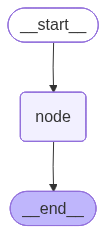

In [181]:
compiled_grph

In [182]:
HITL_res = await compiled_grph.ainvoke(HITL_test_state, config=HITL_config)

In [183]:
HITL_res['__interrupt__'][0].value['selections']

[{'type': 'lodging',
  'task': 'Choose lodging option',
  'options': [{'id': None,
    'name': 'Hotel Le Marais',
    'address': '123 Rue de Rivoli, Paris',
    'price_level': '$$',
    'rating': 4.5,
    'reviews': None,
    'photos': None,
    'url': None,
    'lat': None,
    'lon': None,
    'evidence_score': 0.0,
    'source_id': None,
    'notes': None,
    'area': 'Le Marais',
    'price_night': 160.0,
    'cancel_policy': 'Free cancellation up to 24 hours'}]},
 {'type': 'intercity_transport',
  'task': 'Choose intercity_transport option',
  'options': [{'name': 'Flight NYC-Paris',
    'fare_class': 'Economy',
    'refundable': False,
    'url': None,
    'price': 450.0,
    'transfer': [{'name': 'Direct Flight',
      'place': 'JFK to CDG',
      'departure_time': '21:00',
      'arrival_time': '10:00',
      'duration_min': 420}],
    'total_duration_min': 420,
    'note': None}]},
 {'type': 'activities',
  'task': 'Choose activity option',
  'options': [{'id': None,
    'name

In [184]:
HITL_res

{'messages': [HumanMessage(content='Plan a trip to Paris', additional_kwargs={}, response_metadata={}, id='ac96ecbf-0aa0-4014-8c7a-76166a2c7a2a'),
  AIMessage(content="I'll help you plan your trip to Paris", additional_kwargs={}, response_metadata={}, id='cc6af7e9-649e-482e-87ea-aa64cef45c66')],
 'research_plan': ResearchPlan(lodging_candidates=CandidateResearch(name='lodging', description=None, candidates_number=3), activities_candidates=CandidateResearch(name='activities', description=None, candidates_number=2), food_candidates=CandidateResearch(name='food', description=None, candidates_number=1), intercity_transport_candidates=None),
 'lodging': LodgingAgentOutput(lodging=[CandidateLodging(id=None, name='Hotel Le Marais', address='123 Rue de Rivoli, Paris', price_level='$$', rating=4.5, reviews=None, photos=None, url=None, lat=None, lon=None, evidence_score=0.0, source_id=None, notes=None, area='Le Marais', price_night=160.0, cancel_policy='Free cancellation up to 24 hours')]),
 'ac

In [185]:
resume_data_HITL = human_input(HITL_res)


RESEARCH PLAN CONFIGURATION
Configure how many candidates you want for each category.
Leave empty to use defaults or skip categories.

--- Lodging/Accommodation ---
Do you want to configure Lodging/Accommodation? [y/N]: N

--- Activities/Attractions ---
Do you want to configure Activities/Attractions? [y/N]: N

--- Food/Restaurants ---
Do you want to configure Food/Restaurants? [y/N]: N

--- Intercity Transport ---
Do you want to configure Intercity Transport? [y/N]: N

OPTION SELECTIONS

=== Choose lodging option ===
0: Hotel Le Marais - Le Marais - €160.0/night

Select one option (0-0): 0
Selected: Hotel Le Marais

=== Choose intercity_transport option ===
0: Flight NYC-Paris - $450.0 (Economy)

Select one option (0-0): 0
Selected: Flight NYC-Paris

=== Choose activity option ===
0: Eiffel Tower - €28.0 - 120 min

Do you want to (k)eep selected options or (d)elete selected options? [k/d]: k
Enter option numbers separated by commas (e.g., 0,2,3) or 'all' for all options: all
Processi

In [188]:
resume_data_HITL

{'lodging': {'id': None,
  'name': 'Hotel Le Marais',
  'address': '123 Rue de Rivoli, Paris',
  'price_level': '$$',
  'rating': 4.5,
  'reviews': None,
  'photos': None,
  'url': None,
  'lat': None,
  'lon': None,
  'evidence_score': 0.0,
  'source_id': None,
  'notes': None,
  'area': 'Le Marais',
  'price_night': 160.0,
  'cancel_policy': 'Free cancellation up to 24 hours'},
 'intercity_transport': {'name': 'Flight NYC-Paris',
  'fare_class': 'Economy',
  'refundable': False,
  'url': None,
  'price': 450.0,
  'transfer': [{'name': 'Direct Flight',
    'place': 'JFK to CDG',
    'departure_time': '21:00',
    'arrival_time': '10:00',
    'duration_min': 420}],
  'total_duration_min': 420,
  'note': None},
 'activities': {'id': None,
  'name': 'Eiffel Tower',
  'address': 'Champ de Mars, Paris',
  'price_level': '$$',
  'rating': 4.8,
  'reviews': None,
  'photos': None,
  'url': None,
  'lat': None,
  'lon': None,
  'evidence_score': 0.0,
  'source_id': None,
  'notes': None,
  'o

In [189]:
resumed_res = await compiled_grph.ainvoke(
    Command(resume=resume_data_HITL),
    config=HITL_config
)

In [190]:
resumed_res

{'messages': [HumanMessage(content='Plan a trip to Paris', additional_kwargs={}, response_metadata={}, id='ac96ecbf-0aa0-4014-8c7a-76166a2c7a2a'),
  AIMessage(content="I'll help you plan your trip to Paris", additional_kwargs={}, response_metadata={}, id='cc6af7e9-649e-482e-87ea-aa64cef45c66'),
  HumanMessage(content='Human review completed', additional_kwargs={}, response_metadata={}, id='54cb263e-f247-41d5-b3d3-a398ef165c9a')],
 'research_plan': None,
 'lodging': {'lodging': [{'id': None,
    'name': 'Hotel Le Marais',
    'address': '123 Rue de Rivoli, Paris',
    'price_level': '$$',
    'rating': 4.5,
    'reviews': None,
    'photos': None,
    'url': None,
    'lat': None,
    'lon': None,
    'evidence_score': 0.0,
    'source_id': None,
    'notes': None,
    'area': 'Le Marais',
    'price_night': 160.0,
    'cancel_policy': 'Free cancellation up to 24 hours'}]},
 'activities': {'activities': [{'id': None,
    'name': 'Eiffel Tower',
    'address': 'Champ de Mars, Paris',
   

#Creating graph

In [297]:
graph_builder = StateGraph(state_schema=State, context_schema=Context)

# Adding nodes
graph_builder.add_node(budget_estimate, name="budget_estimate")
graph_builder.add_node(research_plan, name="research_plan")
graph_builder.add_node(research_lodging, name="research_lodging")
graph_builder.add_node(research_activities, name="research_activities")
graph_builder.add_node(research_food, name="research_food")
graph_builder.add_node(research_intercity_transport, name="research_intercity_transport")
graph_builder.add_node(research_recommendations, name="research_recommendations")
graph_builder.add_node(combined_human_review, name='combined_human_review')
graph_builder.add_node(planner, name="planner")

# Initial flow
graph_builder.add_edge(START, "budget_estimate")
graph_builder.add_edge("budget_estimate", "research_plan")

# Parallel research
graph_builder.add_edge("research_plan", "research_activities")
graph_builder.add_edge("research_plan", "research_lodging")
graph_builder.add_edge("research_plan", "research_food")
graph_builder.add_edge("research_plan", "research_intercity_transport")
graph_builder.add_edge("research_plan", "research_recommendations")

graph_builder.add_edge("research_activities", "combined_human_review")
graph_builder.add_edge("research_lodging", "combined_human_review")
graph_builder.add_edge("research_food", "combined_human_review")
graph_builder.add_edge("research_intercity_transport", "combined_human_review")
graph_builder.add_edge("research_recommendations", "combined_human_review")

graph_builder.add_conditional_edges("combined_human_review",
                                    path=route_from_human_response)

# Then from combined_human_review to planner
graph_builder.add_edge("planner", END)

# IMPORTANT: Add interrupt_before
memory = InMemorySaver()
research_graph = graph_builder.compile(
    checkpointer=memory
)

#Graph diagram
https://www.mermaidchart.com/d/42a40b12-31ff-4569-9d42-ea1925866f62

#Graph testing

In [298]:
thread_id = f"trip_{uuid.uuid4()}"

In [299]:
config = {
    "recursion_limit": 100,
    "configurable":{"thread_id": thread_id}
}

initial_state = State(messages=[], estimated_budget=None, research_plan=None)

In [301]:
research_res = await research_graph.ainvoke(initial_state, config=config, context=context)

In [302]:
resume_data = human_input(research_res)


RESEARCH PLAN CONFIGURATION
Configure how many candidates you want for each category.
Leave empty to use defaults or skip categories.

--- Lodging/Accommodation ---
Do you want to configure Lodging/Accommodation? [y/N]: y
Name for Lodging/Accommodation: hotels
Description/requirements for Lodging/Accommodation: cozy hotels
Number of Lodging/Accommodation candidates to return (optional): N
Please enter a valid number or leave empty
Number of Lodging/Accommodation candidates to return (optional): N
Please enter a valid number or leave empty
Number of Lodging/Accommodation candidates to return (optional): N
Please enter a valid number or leave empty
Number of Lodging/Accommodation candidates to return (optional): 3

--- Activities/Attractions ---
Do you want to configure Activities/Attractions? [y/N]: N

--- Food/Restaurants ---
Do you want to configure Food/Restaurants? [y/N]: N

--- Intercity Transport ---
Do you want to configure Intercity Transport? [y/N]: N

Research plan configured

In [307]:
resumed_res = await research_graph.ainvoke(Command(resume=resume_data), config=config, context=context)

In [309]:
while resumed_res.get('research_plan'):
  resume_data = human_input(resumed_res)
  resumed_res = await research_graph.ainvoke(Command(resume=resume_data), config=config, context=context)



RESEARCH PLAN CONFIGURATION
Configure how many candidates you want for each category.
Leave empty to use defaults or skip categories.

--- Lodging/Accommodation ---
Do you want to configure Lodging/Accommodation? [y/N]: y
Name for Lodging/Accommodation: hotels
Description/requirements for Lodging/Accommodation: cozy hotels
Number of Lodging/Accommodation candidates to return (optional): 2

--- Activities/Attractions ---
Do you want to configure Activities/Attractions? [y/N]: N

--- Food/Restaurants ---
Do you want to configure Food/Restaurants? [y/N]: N

--- Intercity Transport ---
Do you want to configure Intercity Transport? [y/N]: N

Research plan configured with 1 categories

OPTION SELECTIONS

=== Choose lodging option ===
0: Sakura Hotel Hatagaya - Shibuya - €None/night
1: Mustard Hotel Shimokitazawa - Setagaya / Shimokitazawa - €None/night
2: APA Hotel & Resort Nishishinjuku Gochome Eki Tower - Shibuya / Nishishinjuku - €None/night

Select one option (0-2): 1
Selected: Mustard 

In [310]:
for day in resumed_res['final_plan'].days:
  activities =""
  foods =""

  for activity in day.activities:
    activities += str(activity.model_dump(exclude_none=True)) + "\n"

  for food in day.food:
    foods += str(food.model_dump(exclude_none=True)) + "\n"

  print(f'Day number {day.day_number} ({day.day_date}\nActivities: {activities}\nFood:{foods})')

Day number 1 (2025-10-01
Activities: {'id': 'arrival', 'name': 'Arrival in Tokyo from Seoul', 'address': 'Haneda Airport, Tokyo', 'lat': 35.5533, 'lon': 139.7811, 'evidence_score': 1.0, 'source_id': 'airport', 'notes': 'Flight arrival and transfer to hotel', 'duration_min': 120, 'price': 0.0, 'tags': ['travel']}
{'id': 'checkin', 'name': 'Check-in at Hotel Niwa Tokyo', 'address': '1-1-16 Kanda Misakicho, Chiyoda, Tokyo', 'price_level': '$$', 'rating': 5.0, 'reviews': ['Clean and cozy for couples'], 'photos': ['https://media-cdn.tripadvisor.com/media/photo-w/2c/20/e2/ac/hotel.jpg'], 'url': 'https://www.tripadvisor.com/Hotel_Review-g1066443-d1475716-Reviews-Hotel_Niwa_Tokyo-Chiyoda_Tokyo_Tokyo_Prefecture_Kanto.html', 'lat': 35.700623, 'lon': 139.75668, 'evidence_score': 0.95, 'source_id': 'tripadvisor', 'notes': 'Settle in and relax after flight', 'open_time': '15:00', 'duration_min': 30, 'price': 0.0, 'tags': ['lodging']}
{'id': '1', 'name': 'Senso-ji Temple', 'address': '2-3-1 Asakusa,